# Financial Analysis

<b>This project is a financial analysis of AtliQ Hardware. </b> <br>
<b>In the project I will explore and investigate the financial metrics of the company (gross and net revenue, etc').  </b><br>
<b>I will explore spikes and seasonality on the graphs.  </b><br>
<b>All the conclusions will be supported by charts.</b>


In [1]:
# Importing nedded libriries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Making connection to the DB
con = sqlite3.connect('C:/Users/Daiana/Downloads/atliq_db1.sqlite3')

In [3]:
# Listing all tables in DB
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('dim_customer',), ('dim_product',), ('fact_pre_discount',), ('fact_manufacturing_cost',), ('fact_gross_price',), ('fact_sales_monthly',)]


## Preprocessing

In this section i will check for missing values and duplicated rows

### Table 1: dim_customer

In [7]:
# Seeing 10 rows from table dim_customer
query = """Select * from 
dim_customer
LIMIT 10
"""
dim_customer = pd.read_sql_query(query, con)
dim_customer.head(10)

,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC
5,70004070,Atliq e Store,E-Commerce,Direct,Japan,ROA,APAC
6,70005163,Atliq e Store,E-Commerce,Direct,Pakistan,ROA,APAC
7,70006157,Atliq Exclusive,Brick & Mortar,Direct,Philiphines,ROA,APAC
8,70006158,Atliq e Store,E-Commerce,Direct,Philiphines,ROA,APAC
9,70007198,Atliq Exclusive,Brick & Mortar,Direct,South Korea,ROA,APAC


In [8]:
# Finding the number of distinct regions
query = """SELECT COUNT(DISTINCT region) AS num_distinct_regions
FROM dim_customer"""
num_distinct_regions = pd.read_sql_query(query, con)
display(num_distinct_regions)

,num_distinct_regions
0,4


In [9]:
# Finding the number of distinct markets
query = """SELECT COUNT(DISTINCT market) AS num_distinct_markets
FROM dim_customer"""
num_distinct_markets = pd.read_sql_query(query, con)
display(num_distinct_markets)

,num_distinct_markets
0,27


In [10]:
# Searching for missing values
query = """SELECT *
FROM dim_customer
WHERE region IS NULL
   OR market IS NULL
   OR customer IS NULL
   OR platform IS NULL
   OR channel IS NULL
   OR sub_zone IS NULL
   OR customer_code IS NULL;
"""
dim_customer_null = pd.read_sql_query(query, con)
display(dim_customer_null)

,customer_code,customer,platform,channel,market,sub_zone,region


In [11]:
# Searching for duplicated customer ID
query = """SELECT customer_code, COUNT(*) AS occurrences
FROM dim_customer
GROUP BY customer_code
HAVING COUNT(*) > 1;
"""
customer_codes = pd.read_sql_query(query, con)
display(customer_codes)

,customer_code,occurrences


<b>See function below:</b>

In [13]:
def check_missing_values(df):
    """
    Check for missing values in each column of a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to check.

    Returns:
        pd.DataFrame: A summary table with column names, number of missing values, 
                      and percentage of missing values.
    """
    missing_count = df.isnull().sum()    
    if missing_count.sum() == 0:
        print("No missing values found in the DataFrame.")
    else:
        print("Missing values:")


In [14]:
# Searching for missing values
query = """SELECT *
FROM dim_customer;
"""
dim_customer_null = pd.read_sql_query(query, con)
check_missing_values(dim_customer_null)

No missing values found in the DataFrame.


In [15]:
def get_duplicated_rows(df):
    """
    Get the duplicated rows in the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to check for duplicates.

    Returns:
        pd.DataFrame: A DataFrame containing the duplicated rows.
    """
    # Get duplicated rows
    duplicated_rows = df[df.duplicated()]

    if duplicated_rows.empty:
        print("No duplicated rows found.")
    else:
        print(f"Duplicated rows found: {len(duplicated_rows)}")
    
    return duplicated_rows

In [16]:
get_duplicated_rows(dim_customer_null)

No duplicated rows found.


,customer_code,customer,platform,channel,market,sub_zone,region


### Table 2: dim_product

In [12]:
# Seeing 10 rows from tabledim_product
query = """Select * from 
dim_product
LIMIT 10
"""
dim_product = pd.read_sql_query(query, con)
dim_product.head(10)

,product_code,division,segment,category,product,variant
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard
5,A0219150202,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Plus
6,A0220150203,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium
7,A0320150301,P & A,Peripherals,Internal HDD,AQ Zion Saga,Standard
8,A0321150302,P & A,Peripherals,Internal HDD,AQ Zion Saga,Plus
9,A0321150303,P & A,Peripherals,Internal HDD,AQ Zion Saga,Premium


In [13]:
# Searching for missing values
query = """SELECT *
FROM dim_product
WHERE product_code IS NULL
   OR division IS NULL
   OR segment IS NULL
   OR category IS NULL
   OR product IS NULL
   OR variant IS NULL;
"""
dim_product_null = pd.read_sql_query(query, con)
display(dim_product_null)

,product_code,division,segment,category,product,variant


In [14]:
# Searching for duplicated product ID
query = """SELECT product_code, COUNT(*) AS occurrences
FROM dim_product
GROUP BY product_code
HAVING COUNT(*) > 1;
"""
product_codes = pd.read_sql_query(query, con)
display(product_codes)

,product_code,occurrences


In [15]:
# Searching for duplicated product name + variant
query = """SELECT *
FROM dim_product
WHERE (product, variant) IN (
    SELECT product, variant
    FROM dim_product
    GROUP BY product, variant
    HAVING COUNT(*) > 1);

"""
product_names = pd.read_sql_query(query, con)
display(product_names)

,product_code,division,segment,category,product,variant


In [17]:
# Searching for missing values and duplicated rows
query = """SELECT *
FROM dim_product;
"""
dim_product_null = pd.read_sql_query(query, con)
check_missing_values(dim_product_null)
get_duplicated_rows(dim_product_null)

No missing values found in the DataFrame.
No duplicated rows found.


,product_code,division,segment,category,product,variant


### Table 3: fact_pre_discount

In [16]:
# Seeing 10 rows from table fact_pre_discount
query = """Select * from 
fact_pre_discount
LIMIT 10;
"""
fact_pre_discount = pd.read_sql_query(query, con)
fact_pre_discount.head(10)

,customer_code,fiscal_year,pre_invoice_discount_pct
0,70002017,2018,0.0824
1,70002017,2019,0.0777
2,70002017,2020,0.0735
3,70002017,2021,0.0703
4,70002017,2022,0.1057
5,70002018,2018,0.2956
6,70002018,2019,0.2577
7,70002018,2020,0.2255
8,70002018,2021,0.2061
9,70002018,2022,0.2931


In [17]:
# Searching for missing values
query = """SELECT *
FROM fact_pre_discount
WHERE customer_code IS NULL
   OR fiscal_year IS NULL
   OR pre_invoice_discount_pct IS NULL;
"""
fact_pre_discount_null = pd.read_sql_query(query, con)
display(fact_pre_discount_null)

,customer_code,fiscal_year,pre_invoice_discount_pct


In [18]:
# Searching for duplicated customer name + year
query = """SELECT *
FROM fact_pre_discount
WHERE (customer_code, fiscal_year) IN (
    SELECT customer_code, fiscal_year
    FROM fact_pre_discount
    GROUP BY customer_code, fiscal_year
    HAVING COUNT(*) > 1);

"""
product_names_dis = pd.read_sql_query(query, con)
display(product_names_dis)

,customer_code,fiscal_year,pre_invoice_discount_pct


In [19]:
# Searching for missing values and duplicated rows
query = """SELECT *
FROM fact_pre_discount;
"""
fact_pre_discount_null = pd.read_sql_query(query, con)
check_missing_values(fact_pre_discount_null)
get_duplicated_rows(fact_pre_discount_null)

No missing values found in the DataFrame.
No duplicated rows found.


,customer_code,fiscal_year,pre_invoice_discount_pct


### Table 4: fact_manufacturing_cost

In [19]:
# Seeing 10 rows from table
query = """Select * from 
fact_manufacturing_cost
LIMIT 10
"""
fact_manufacturing_cost = pd.read_sql_query(query, con)
fact_manufacturing_cost.head(10)

,product_code,cost_year,manufacturing_cost
0,A0118150101,2018,4.6190
1,A0118150101,2019,4.2033
2,A0118150101,2020,5.0207
3,A0118150101,2021,5.5172
4,A0118150102,2018,5.6036
5,A0118150102,2019,5.3235
6,A0118150102,2020,5.7180
7,A0118150102,2021,6.2835
8,A0118150103,2018,5.9469
9,A0118150103,2019,5.5306


In [20]:
# Searching for missing values
query = """SELECT *
FROM fact_manufacturing_cost
WHERE product_code IS NULL
   OR cost_year IS NULL
   OR manufacturing_cost IS NULL;
"""
fact_manufacturing_cost_null = pd.read_sql_query(query, con)
display(fact_manufacturing_cost_null)

,product_code,cost_year,manufacturing_cost


In [21]:
# Searching for duplicated product + year
query = """SELECT *
FROM fact_manufacturing_cost
WHERE (product_code, cost_year) IN (
    SELECT product_code, cost_year
    FROM fact_manufacturing_cost
    GROUP BY product_code, cost_year
    HAVING COUNT(*) > 1);

"""
product_codes_yr = pd.read_sql_query(query, con)
display(product_codes_yr)

,product_code,cost_year,manufacturing_cost


In [20]:
# Searching for missing values and duplicated rows
query = """SELECT *
FROM fact_manufacturing_cost;
"""
fact_manufacturing_cost_null = pd.read_sql_query(query, con)
check_missing_values(fact_manufacturing_cost_null)
get_duplicated_rows(fact_manufacturing_cost_null)

No missing values found in the DataFrame.
No duplicated rows found.


,product_code,cost_year,manufacturing_cost


### Table 5: fact_gross_price

In [22]:
# Seeing 10 rows from table
query = """Select * from 
fact_gross_price
LIMIT 10
"""
fact_gross_price = pd.read_sql_query(query, con)
fact_gross_price.head(10)

,product_code,fiscal_year,gross_price
0,A0118150101,2018,15.3952
1,A0118150101,2019,14.4392
2,A0118150101,2020,16.2323
3,A0118150101,2021,19.0573
4,A0118150102,2018,19.5875
5,A0118150102,2019,18.5595
6,A0118150102,2020,19.8577
7,A0118150102,2021,21.4565
8,A0118150103,2018,19.3630
9,A0118150103,2019,19.3442


In [23]:
# Searching for missing values
query = """SELECT *
FROM fact_gross_price
WHERE product_code IS NULL
   OR fiscal_year IS NULL
   OR gross_price IS NULL;
"""
fact_gross_price_null = pd.read_sql_query(query, con)
display(fact_gross_price_null)

,product_code,fiscal_year,gross_price


In [24]:
# Searching for duplicated product + year
query = """SELECT *
FROM fact_gross_price
WHERE (product_code, fiscal_year) IN (
    SELECT product_code, fiscal_year
    FROM fact_gross_price
    GROUP BY product_code, fiscal_year
    HAVING COUNT(*) > 1);

"""
product_codes_gr = pd.read_sql_query(query, con)
display(product_codes_gr)

,product_code,fiscal_year,gross_price


In [21]:
# Searching for missing values and duplicated rows
query = """SELECT *
FROM fact_gross_price;
"""
fact_gross_price_null = pd.read_sql_query(query, con)
check_missing_values(fact_gross_price_null)
get_duplicated_rows(fact_gross_price_null)

No missing values found in the DataFrame.
No duplicated rows found.


,product_code,fiscal_year,gross_price


### Table 6: fact_sales_monthly

In [102]:
# Seeing 10 rows from table
query = """Select * from 
fact_sales_monthly
ORDER BY sold_quantity
LIMIT 10
"""
fact_sales_monthly = pd.read_sql_query(query, con)
fact_sales_monthly.head(10)

,date,product_code,customer_code,sold_quantity,fiscal_year
0,2017-09-01,A0118150101,70012042,0,2018
1,2017-09-01,A0118150101,70012043,0,2018
2,2017-09-01,A0118150101,90012033,0,2018
3,2017-09-01,A0118150101,90012034,0,2018
4,2017-09-01,A0118150101,90012035,0,2018
5,2017-09-01,A0118150101,90012037,0,2018
6,2017-09-01,A0118150101,90012038,0,2018
7,2017-09-01,A0118150101,90012039,0,2018
8,2017-09-01,A0118150101,90012041,0,2018
9,2017-09-01,A0118150102,70012042,0,2018


In [84]:
# Searching for missing values
query = """SELECT *
FROM fact_sales_monthly
WHERE product_code IS NULL
   OR date IS NULL
   OR fiscal_year IS NULL
   OR sold_quantity IS NULL
   OR customer_code IS NULL;
"""
fact_sales_monthly_null = pd.read_sql_query(query, con)
display(fact_sales_monthly_null)

,date,product_code,customer_code,sold_quantity,fiscal_year


In [85]:
# Searching for duplicated product + year
query = """SELECT 
    date,
    product_code,
    customer_code,
    COUNT(*) AS occurrence_count
FROM 
    fact_sales_monthly
GROUP BY 
    date,
    product_code,
    customer_code
HAVING 
    COUNT(*) > 1;
"""
fact_sales_monthly_dup = pd.read_sql_query(query, con)
display(fact_sales_monthly_dup)

,date,product_code,customer_code,occurrence_count


In [22]:
# Searching for missing values and duplicated rows
query = """SELECT *
FROM fact_sales_monthly;
"""
fact_sales_monthly_null = pd.read_sql_query(query, con)
check_missing_values(fact_sales_monthly_null)
get_duplicated_rows(fact_sales_monthly_null)

No missing values found in the DataFrame.
No duplicated rows found.


,date,product_code,customer_code,sold_quantity,fiscal_year


In [86]:
# Looking for other rows with the same date
query = """ SELECT *
    FROM fact_sales_monthly
    WHERE date = '2019-06-01'
"""
fact_sales_monthly_NA = pd.read_sql_query(query, con)
display(fact_sales_monthly_NA)

,date,product_code,customer_code,sold_quantity,fiscal_year
0,2019-06-01,A0118150101,70002017,104,2019
1,2019-06-01,A0118150101,70002018,79,2019
2,2019-06-01,A0118150101,70003181,28,2019
3,2019-06-01,A0118150101,70003182,21,2019
4,2019-06-01,A0118150101,70006157,16,2019
...,...,...,...,...,...
1138,2019-06-01,A0418150104,90013122,10,2019
1139,2019-06-01,A0418150104,90013124,16,2019
1140,2019-06-01,A0418150104,90014136,2,2019
1141,2019-06-01,A0418150104,90014137,1,2019


In [87]:
# Deleting the NA row
cursor.execute("""
    DELETE FROM fact_sales_monthly
    WHERE customer_code IS NULL;
""")
con.commit()

In [30]:
# Confirm deletion
cursor.execute("SELECT COUNT(*) FROM fact_sales_monthly WHERE customer_code IS NULL;")
null_count = cursor.fetchone()[0]
print("Remaining rows with NULL customer_code:", null_count)

Remaining rows with NULL customer_code: 0


There were no duplicated rows in any of the tables of the DB.  
There was one row containing multiple missing values in table fact_sales_monthly.  
The missing row did not contain any information so it was deleted.

## Metrics over Time 

In this section I will calculate and plot gross and net revenue, and manufactoring cost over time.  
I will investigate spikes and seasonality on the graphs.  
I will seperatly plot the possible reasons for the increase in all three metrics by the end of 2021- quntity sold, and price per unit.

In [24]:
# Creating a big joined table of metrics and other needed columns
query = """SELECT
    fsm.fiscal_year,
    fsm.date,
    DATE(strftime('%Y-%m', fsm.date) || '-01') AS month,
    fsm.product_code,
    dp.product,
    dp.category,
    fsm.customer_code,
    dc.customer,
    dc.market,
    fsm.sold_quantity,
    fgp.gross_price,
    fpd.pre_invoice_discount_pct,
    (fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
    (fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
    (fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man

    
FROM fact_sales_monthly fsm

JOIN fact_gross_price fgp
  ON fsm.product_code = fgp.product_code
 AND fsm.fiscal_year = fgp.fiscal_year

JOIN fact_manufacturing_cost fmc
  ON fsm.product_code = fmc.product_code
  AND fsm.fiscal_year = fmc.cost_year

JOIN fact_pre_discount fpd
  ON fsm.customer_code = fpd.customer_code
 AND fsm.fiscal_year = fpd.fiscal_year

JOIN dim_customer dc
  ON fsm.customer_code = dc.customer_code

JOIN dim_product dp
  ON fsm.product_code = dp.product_code
 ;
"""
data = pd.read_sql_query(query, con)
data.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\all_data.csv', index=False)
data.head()

,fiscal_year,date,month,product_code,product,category,customer_code,customer,market,sold_quantity,gross_price,pre_invoice_discount_pct,gross_revenue,net_revenue,gross_man
0,2018,2017-09-01,2017-09-01,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Internal HDD,70002017,Atliq Exclusive,India,51,15.3952,0.0824,785.1552,720.458412,235.569
1,2018,2017-09-01,2017-09-01,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Internal HDD,70002018,Atliq e Store,India,77,15.3952,0.2956,1185.4304,835.017174,355.663
2,2018,2017-09-01,2017-09-01,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Internal HDD,70003181,Atliq Exclusive,Indonesia,17,15.3952,0.0536,261.7184,247.690294,78.523
3,2018,2017-09-01,2017-09-01,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Internal HDD,70003182,Atliq e Store,Indonesia,6,15.3952,0.2378,92.3712,70.405329,27.714
4,2018,2017-09-01,2017-09-01,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Internal HDD,70006157,Atliq Exclusive,Philiphines,5,15.3952,0.1057,76.9760,68.839637,23.095


In [20]:
# Creating a joined table of metrics
query = """SELECT
    fsm.fiscal_year,
    fsm.date,
    fsm.product_code,
    fsm.customer_code,
    fsm.sold_quantity,
    fgp.gross_price,
    fpd.pre_invoice_discount_pct,
    (fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
    (fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
    (fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man

FROM fact_sales_monthly fsm

JOIN fact_gross_price fgp
  ON fsm.product_code = fgp.product_code
 AND fsm.fiscal_year = fgp.fiscal_year

JOIN fact_manufacturing_cost fmc
  ON fsm.product_code = fmc.product_code
  AND fsm.fiscal_year = fmc.cost_year

JOIN fact_pre_discount fpd
  ON fsm.customer_code = fpd.customer_code
 AND fsm.fiscal_year = fpd.fiscal_year;
"""
revenue = pd.read_sql_query(query, con)
revenue.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\revenue_all.csv', index=False)
revenue.head()

,fiscal_year,date,month,product_code,customer_code,sold_quantity,gross_price,pre_invoice_discount_pct,gross_revenue,net_revenue,gross_man
0,2018,2017-09-01,2017-09,A0118150101,70002017,51,15.3952,0.0824,785.1552,720.458412,235.569
1,2018,2017-09-01,2017-09,A0118150101,70002018,77,15.3952,0.2956,1185.4304,835.017174,355.663
2,2018,2017-09-01,2017-09,A0118150101,70003181,17,15.3952,0.0536,261.7184,247.690294,78.523
3,2018,2017-09-01,2017-09,A0118150101,70003182,6,15.3952,0.2378,92.3712,70.405329,27.714
4,2018,2017-09-01,2017-09,A0118150101,70006157,5,15.3952,0.1057,76.9760,68.839637,23.095


In [32]:
# Creating a joined table of metrics by month
query = """SELECT
    month,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    GROUP BY month
)
ORDER BY month;
"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,203560.7803,153549.701158,60487.6785,1.535497e+05,2.035608e+05,60487.6785,234.069666,11425,13.439799
1,2017-10,264533.7946,204034.466872,78490.0838,3.575842e+05,4.680946e+05,138977.7623,340.057445,14860,13.730449
2,2017-11,375191.4062,286992.281537,111272.7596,6.445764e+05,8.432860e+05,250250.5219,481.530674,21012,13.658494
3,2017-12,385598.6583,290756.322045,114595.9086,9.353328e+05,1.228885e+06,364846.4305,491.973472,21615,13.451599
4,2018-01,208699.9808,158192.241717,61910.3780,1.093525e+06,1.437585e+06,426756.8085,268.122444,11713,13.505698


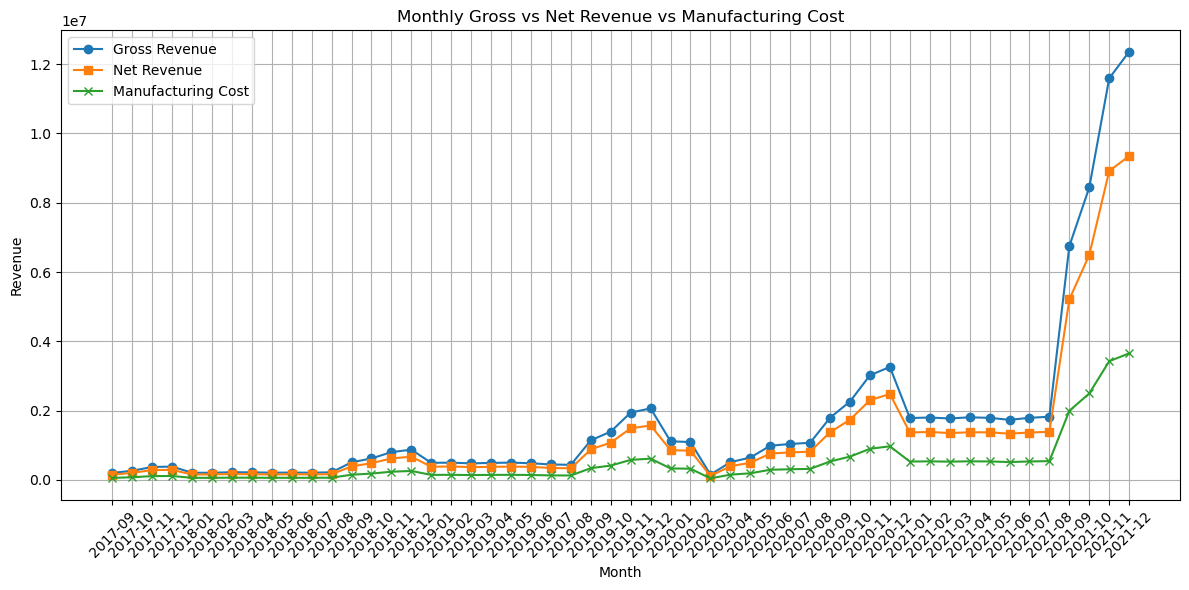

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month'], df_monthly['gross_revenue'], marker='o', label='Gross Revenue')
plt.plot(df_monthly['month'], df_monthly['net_revenue'], marker='s', label='Net Revenue')
plt.plot(df_monthly['month'], df_monthly['gross_man'], marker='x', label='Manufacturing Cost')
plt.title('Monthly Gross vs Net Revenue vs Manufacturing Cost')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Gross Revenue, Net Revenue, and Manufacturing Costs- Trend Analysis:
1. 2017-09 to 2019-07:
All three lines (Gross Revenue, Net Revenue, and Manufacturing Cost) are relatively flat and low.  
There is a small spike in three metrics between 2018-08 and 2018-12.  
Revenue is stable.
2. 2019-08 to 2020-02:
First noticeable growth phase.  
Gross and Net Revenue both increase, indicating improved sales.  
Manufacturing Cost increases in parallel, but the margin appears to widen slightly.
3. 2020-03 to 2020-07:
Slow increase in all three metrics.  
Possible reason: COVID-19-related disruptions.
4. 2020-08 to 2021-06:
Recovery and new growth phase.  
Metrics rebound and stabilize at a higher level.  
Gross Revenue slightly exceeds Net Revenue consistently, indicating healthy but consistent operational costs.
5. 2021-07 to 2021-12:
Sharp growth in all metrics — especially Gross and Net Revenue.  
Manufacturing Cost also rises, but at a slower pace than revenues — indicating increased efficiency or economies of scale.
6. In 2021, the revenue and manufacturing cost rise rapidly from July to December.  
In previous years (2017–2020), this pattern does not repeat in a meaningfull way, even though we can see that those months represent a small increase in all metrics relatively to the rest of the year.

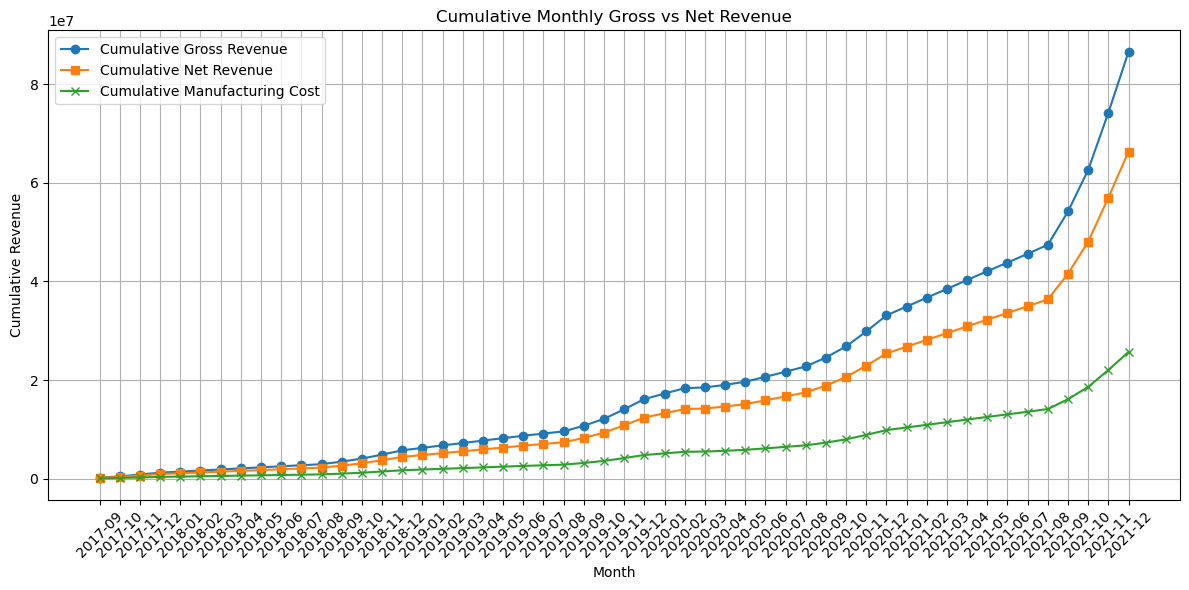

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month'], df_monthly['cumulative_gross_revenue'], marker='o', label='Cumulative Gross Revenue')
plt.plot(df_monthly['month'], df_monthly['cumulative_net_revenue'], marker='s', label='Cumulative Net Revenue')
plt.plot(df_monthly['month'], df_monthly['cumulative_gross_man'], marker='x', label='Cumulative Manufacturing Cost')
plt.title('Cumulative Monthly Gross vs Net Revenue')
plt.xlabel('Month')
plt.ylabel('Cumulative Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2017–2019: All lines rise slowly and steadily, indicating modest and consistent business growth.  
2020: There is a visible step-up in growth after the COVID dip, especially in revenue.  
2021: The cumulative gross and net revenue lines curve upwards more sharply, showing accelerated growth, especially in the last six months. Manufacturing cost also increases, but the curve is less steep than revenue.  
Revenue vs. Cost Dynamics
1. The gap between cumulative net revenue and cumulative manufacturing cost widens over time, meaning the business is not only growing but doing so more efficiently.
2. The gap between gross and net revenue stays relatively consistent, showing that operating costs (other than manufacturing) remain stable as a share of revenue.
In this plot we can see that tere is no strong seasonality.

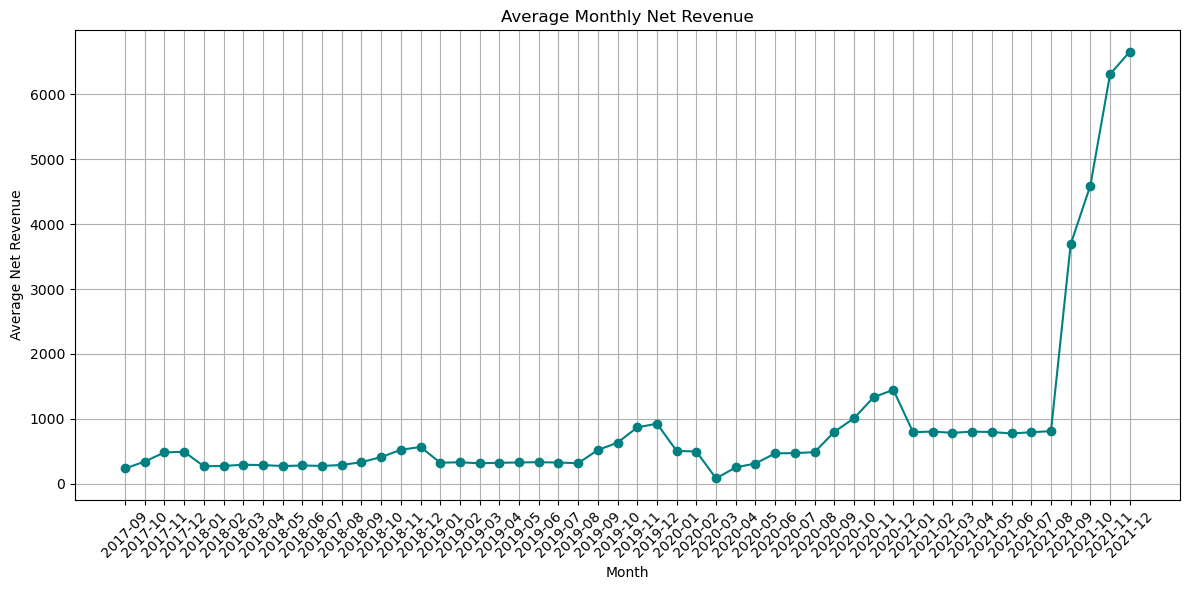

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month'], df_monthly['avg_net_revenue'], marker='o', linestyle='-', color='teal')
plt.title('Average Monthly Net Revenue')
plt.xlabel('Month')
plt.ylabel('Average Net Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

This plot is very similar to Monthly Gross vs Net Revenue plot.  
There is no new information.

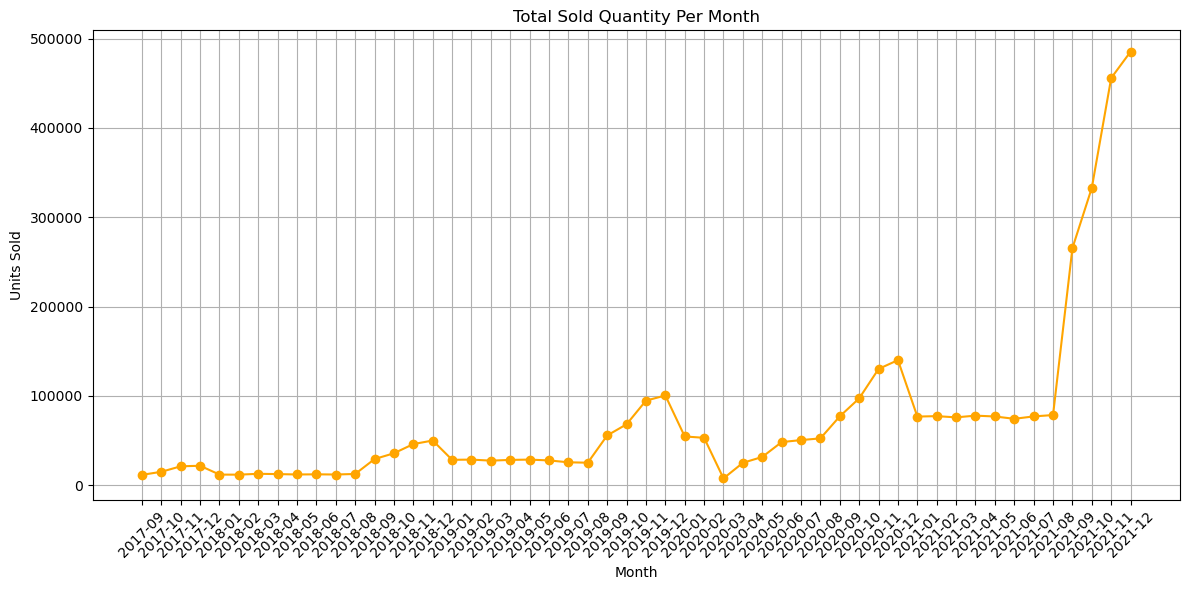

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month'], df_monthly['total_sold_quantity'], marker='o', linestyle='-', color='orange')
plt.title('Total Sold Quantity Per Month')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

2017–2019: Stable, Low Sales: Units sold per month are quite low and steady, with only minor fluctuations.  
Occasional small increases, but the overall trend is flat.  
2020: Spike and Dip: There is a clear rise in monthly units sold in early 2020, followed by a sharp drop (likely due to the COVID-19 pandemic).
Quick Recovery- Sales recover rapidly after the dip, returning to or exceeding previous highs.  
2021: Explosive Growth: Starting around July 2021, there is a dramatic and sustained increase in monthly units sold, peaking above 500,000 by the end of the year.  
The rapid increase in units sold in the second half of 2021 suggests a major change—possibly a new product, new market, or highly successful campaign.

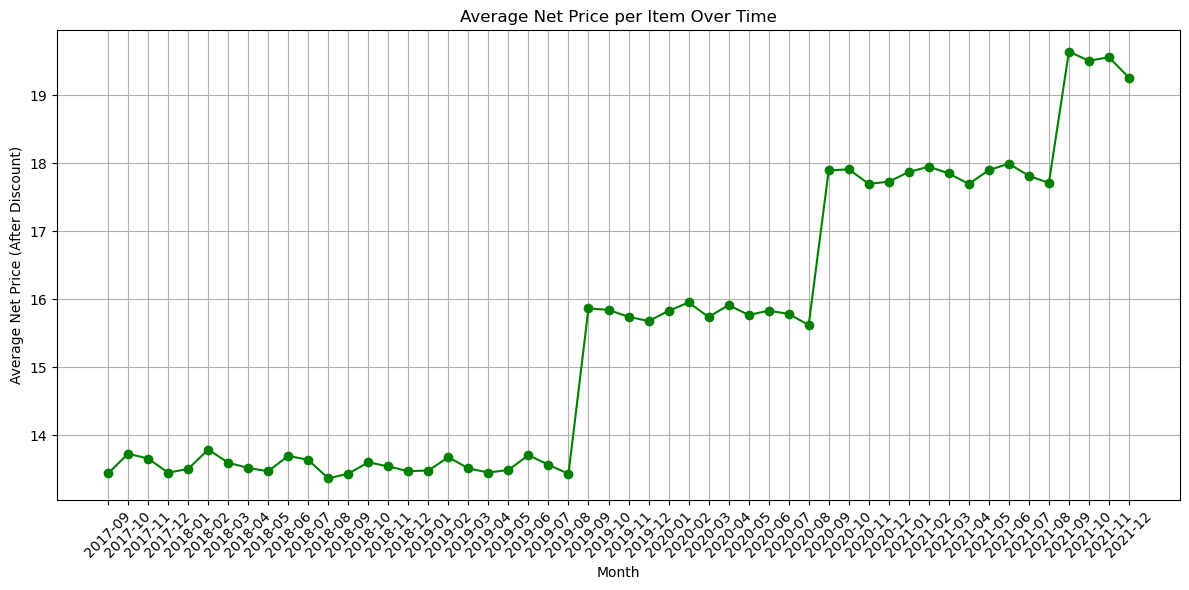

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month'], df_monthly['avg_net_price_per_item'], marker='o', linestyle='-', color='green')
plt.title('Average Net Price per Item Over Time')
plt.xlabel('Month')
plt.ylabel('Average Net Price (After Discount)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


2017–mid 2019: The average net price per item is steady, fluctuating slightly around 13–14.  
Stable pricing during this period, suggesting little to no price adjustment or discounting.  
Mid-2019: There is a sudden jump in price to around 16.  
After this step up, the price stabilizes at this new level.  
Late 2020: Another sudden jump in average price to about 18.  
Mid-2021: A third jump, this time to around 19–20, where it remains for the rest of the period.

## Metrics by Product

In this section I will investigate and plot metrics by product and product category.  
find the most and least profitable products and categories.

In [40]:
# Finding the number of distinct divisions
query = """SELECT DISTINCT division AS num_distinct_divisions
FROM dim_product"""
num_distinct_divisions = pd.read_sql_query(query, con)
display(num_distinct_divisions)

,num_distinct_divisions
0,P & A
1,PC
2,N & S


In [41]:
# Finding the number of distinct segments
query = """SELECT DISTINCT segment AS num_distinct_segments
FROM dim_product"""
num_distinct_segments = pd.read_sql_query(query, con)
display(num_distinct_segments)

,num_distinct_segments
0,Peripherals
1,Accessories
2,Notebook
3,Desktop
4,Storage
5,Networking


In [88]:
# Finding the number of distinct categories
query = """SELECT DISTINCT category AS num_distinct_categories
FROM dim_product"""
num_distinct_categories = pd.read_sql_query(query, con)
display(num_distinct_categories)

,num_distinct_categories
0,Internal HDD
1,Graphic Card
2,Processors
3,MotherBoard
4,Mouse
5,Keyboard
6,Batteries
7,Personal Laptop
8,Business Laptop
9,Gaming Laptop


In [111]:
# Creating a joind table of metrics
query = """SELECT
    fsm.fiscal_year,
    fsm.date,
    fsm.product_code,
    fsm.customer_code,
    fsm.sold_quantity,
    fgp.gross_price,
    fpd.pre_invoice_discount_pct,
    (fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
    (fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
    (fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
    dp.division,
    dp.category,
    dp.segment,
    dp.variant,
    dp.product
    

FROM fact_sales_monthly fsm

JOIN fact_gross_price fgp
  ON fsm.product_code = fgp.product_code
 AND fsm.fiscal_year = fgp.fiscal_year

JOIN fact_manufacturing_cost fmc
  ON fsm.product_code = fmc.product_code
  AND fsm.fiscal_year = fmc.cost_year

JOIN fact_pre_discount fpd
  ON fsm.customer_code = fpd.customer_code
 AND fsm.fiscal_year = fpd.fiscal_year
 
LEFT JOIN dim_product dp
  ON fsm.product_code = dp.product_code
 ;
"""
revenue = pd.read_sql_query(query, con)
revenue.head(10)

,fiscal_year,date,product_code,customer_code,sold_quantity,gross_price,pre_invoice_discount_pct,gross_revenue,net_revenue,gross_man,division,category,segment,variant,product
0,2018,2017-09-01,A0118150101,70002017,51,15.3952,0.0824,785.1552,720.458412,235.569,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
1,2018,2017-09-01,A0118150101,70002018,77,15.3952,0.2956,1185.4304,835.017174,355.663,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
2,2018,2017-09-01,A0118150101,70003181,17,15.3952,0.0536,261.7184,247.690294,78.523,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
3,2018,2017-09-01,A0118150101,70003182,6,15.3952,0.2378,92.3712,70.405329,27.714,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
4,2018,2017-09-01,A0118150101,70006157,5,15.3952,0.1057,76.9760,68.839637,23.095,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
5,2018,2017-09-01,A0118150101,70006158,7,15.3952,0.1875,107.7664,87.560200,32.333,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
6,2018,2017-09-01,A0118150101,70007198,29,15.3952,0.0700,446.4608,415.208544,133.951,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
7,2018,2017-09-01,A0118150101,70007199,34,15.3952,0.2551,523.4368,389.908072,157.046,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
8,2018,2017-09-01,A0118150101,70008169,22,15.3952,0.0953,338.6944,306.416824,101.618,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
9,2018,2017-09-01,A0118150101,70008170,5,15.3952,0.1896,76.9760,62.381350,23.095,P & A,Internal HDD,Peripherals,Standard,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...


In [77]:
# Creating a joined table of metrics by division
query = """SELECT
    strftime('%Y-%m', fsm.date) AS month,
    dp.division as division,
    SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
    SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
    SUM (fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
    SUM(SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)))
        OVER (ORDER BY strftime('%Y-%m', fsm.date)) AS cumulative_net_revenue,  
    SUM(SUM(fsm.sold_quantity * gross_price))
        OVER (ORDER BY strftime('%Y-%m', fsm.date)) AS cumulative_gross_revenue,
    SUM(SUM(fsm.sold_quantity * fmc.manufacturing_cost))
        OVER (ORDER BY strftime('%Y-%m', fsm.date)) AS cumulative_gross_man,
    AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
    SUM(sold_quantity) AS total_sold_quantity,
    SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 / 
        SUM(fsm.sold_quantity) AS avg_net_price_per_item

FROM fact_sales_monthly fsm

JOIN fact_gross_price fgp
  ON fsm.product_code = fgp.product_code
 AND fsm.fiscal_year = fgp.fiscal_year

JOIN fact_manufacturing_cost fmc
  ON fsm.product_code = fmc.product_code
  AND fsm.fiscal_year = fmc.cost_year
  
JOIN fact_pre_discount fpd
  ON fsm.customer_code = fpd.customer_code
 AND fsm.fiscal_year = fpd.fiscal_year

JOIN dim_product dp
  ON fsm.product_code = dp.product_code

GROUP BY month, division
ORDER BY month, division;
"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head(10)

,month,division,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,P & A,203560.7803,153549.701158,60487.6785,1.535497e+05,2.035608e+05,60487.6785,234.069666,11425,13.439799
1,2017-10,P & A,264533.7946,204034.466872,78490.0838,3.575842e+05,4.680946e+05,138977.7623,340.057445,14860,13.730449
2,2017-11,P & A,375191.4062,286992.281537,111272.7596,6.445764e+05,8.432860e+05,250250.5219,481.530674,21012,13.658494
3,2017-12,P & A,385598.6583,290756.322045,114595.9086,9.353328e+05,1.228885e+06,364846.4305,491.973472,21615,13.451599
4,2018-01,P & A,208699.9808,158192.241717,61910.3780,1.093525e+06,1.437585e+06,426756.8085,268.122444,11713,13.505698
5,2018-02,P & A,207606.7507,160756.970790,61546.8693,1.254282e+06,1.645191e+06,488303.6778,272.932039,11657,13.790595
6,2018-03,P & A,224224.7392,171384.244268,66595.6921,1.425666e+06,1.869416e+06,554899.3699,291.469803,12603,13.598686
7,2018-04,P & A,219503.8709,166055.177703,65155.5548,1.591721e+06,2.088920e+06,620054.9247,286.302031,12282,13.520207
8,2018-05,P & A,210569.3188,159615.663738,62521.4483,1.751337e+06,2.299489e+06,682576.3730,271.455210,11847,13.473087
9,2018-06,P & A,213202.6890,164623.821259,63227.6383,1.915961e+06,2.512692e+06,745804.0113,279.972485,12018,13.698105


In [89]:
# Finding the number of distinct divisions
query = """SELECT DISTINCT dp.division AS num_distinct_divisions
FROM fact_sales_monthly fsm
JOIN dim_product dp
    ON fsm.product_code = dp.product_code
"""
distinct_divisions = pd.read_sql_query(query, con)
display(distinct_divisions)

,num_distinct_divisions
0,P & A


In [90]:
# Finding the number of distinct categories
query = """SELECT DISTINCT dp.category AS num_distinct_categories
FROM fact_sales_monthly fsm
JOIN dim_product dp
    ON fsm.product_code = dp.product_code
"""
distinct_categories = pd.read_sql_query(query, con)
display(distinct_categories)

,num_distinct_categories
0,Internal HDD
1,Graphic Card


In [82]:
# Finding the number of distinct segments
query = """SELECT DISTINCT dp.segment AS num_distinct_segments
FROM fact_sales_monthly fsm
JOIN dim_product dp
    ON fsm.product_code = dp.product_code
"""
distinct_segments = pd.read_sql_query(query, con)
display(distinct_segments)

,num_distinct_segments
0,Peripherals


In [85]:
# Finding the number of distinct variants
query = """SELECT DISTINCT dp.variant AS num_distinct_variants
FROM fact_sales_monthly fsm
JOIN dim_product dp
    ON fsm.product_code = dp.product_code
"""
distinct_variants = pd.read_sql_query(query, con)
display(distinct_variants)

,num_distinct_variants
0,Standard
1,Plus
2,Premium
3,Premium Plus
4,Standard 1
5,Standard 2
6,Standard 3
7,Plus 1


In [95]:
# Creating a joined table of metrics by category
query = """SELECT
    month,
    category,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY category ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY category ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY category ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dp.category AS category,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_product dp
      ON fsm.product_code = dp.product_code
    GROUP BY month, dp.category
)
ORDER BY month, category;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head(10)

,month,category,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,Graphic Card,106794.2612,80225.980718,31552.6677,80225.980718,106794.2612,31552.6677,243.847966,6188,12.964767
1,2017-09,Internal HDD,96766.5191,73323.720440,28935.0108,73323.720440,96766.5191,28935.0108,224.231561,5237,14.001092
2,2017-10,Graphic Card,144951.2396,111569.559896,42801.4781,191795.540614,251745.5008,74354.1458,373.142341,8388,13.301092
3,2017-10,Internal HDD,119582.5550,92464.906976,35688.6057,165788.627416,216349.0741,64623.6165,307.192382,6472,14.286914
4,2017-11,Graphic Card,197125.7922,151192.943746,58121.1207,342988.484360,448871.2930,132475.2665,507.358872,11370,13.297532
5,2017-11,Internal HDD,178065.6140,135799.337791,53151.6389,301587.965207,394414.6881,117775.2554,455.702476,9642,14.084146
6,2017-12,Graphic Card,208606.5411,157493.894356,61576.4052,500482.378717,657477.8341,194051.6717,533.877608,12043,13.077630
7,2017-12,Internal HDD,176992.1172,133262.427689,53019.5034,434850.392896,571406.8053,170794.7588,450.210904,9572,13.922109
8,2018-01,Graphic Card,111729.2090,84805.801101,33035.0262,585288.179818,769207.0431,227086.6979,284.583225,6490,13.067150
9,2018-01,Internal HDD,96970.7718,73386.440616,28875.3518,508236.833511,668377.5771,199670.1106,251.323427,5223,14.050630


In [96]:
# Pivot the DataFrame so each category is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='category', values='gross_revenue')
df_pivot = df_pivot.fillna(0)

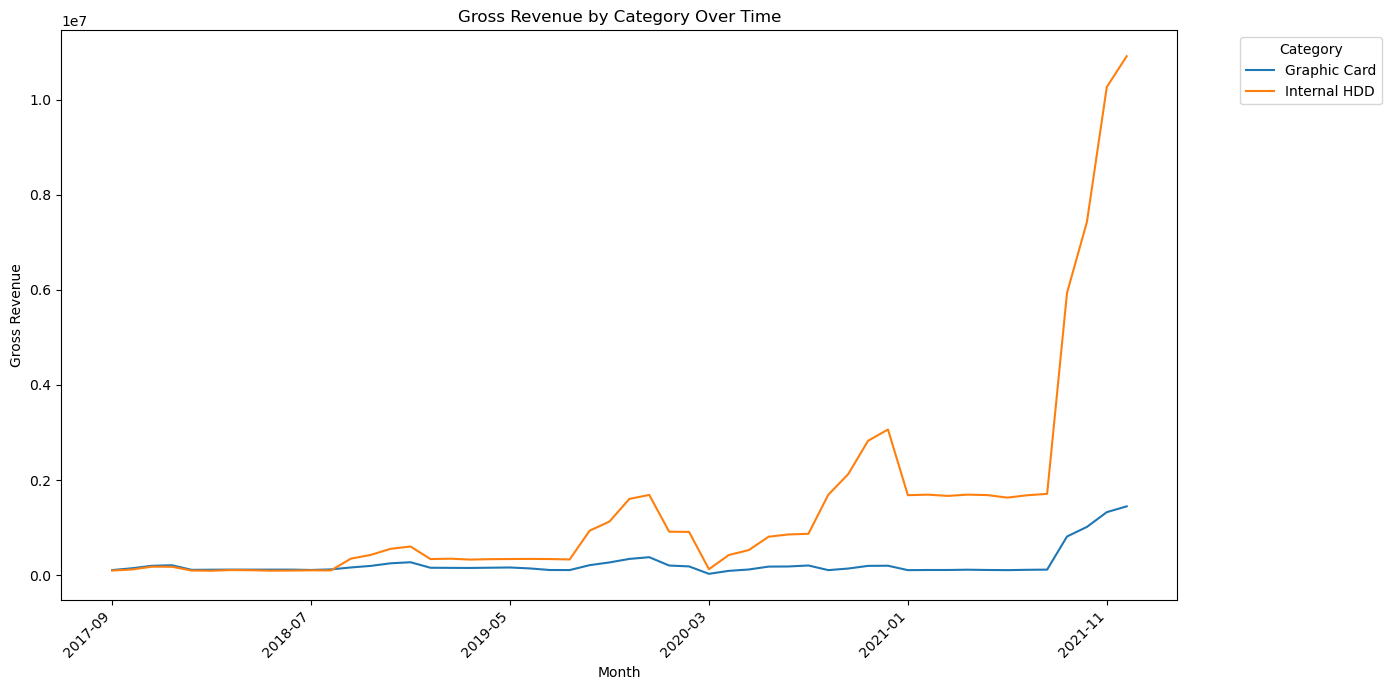

In [97]:
# Plotting gross revenue by product category
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Gross Revenue by Category Over Time')
plt.xlabel('Month')
plt.ylabel('Gross Revenue')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [92]:
# Pivot the DataFrame so each category is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='category', values='net_revenue')
df_pivot = df_pivot.fillna(0)

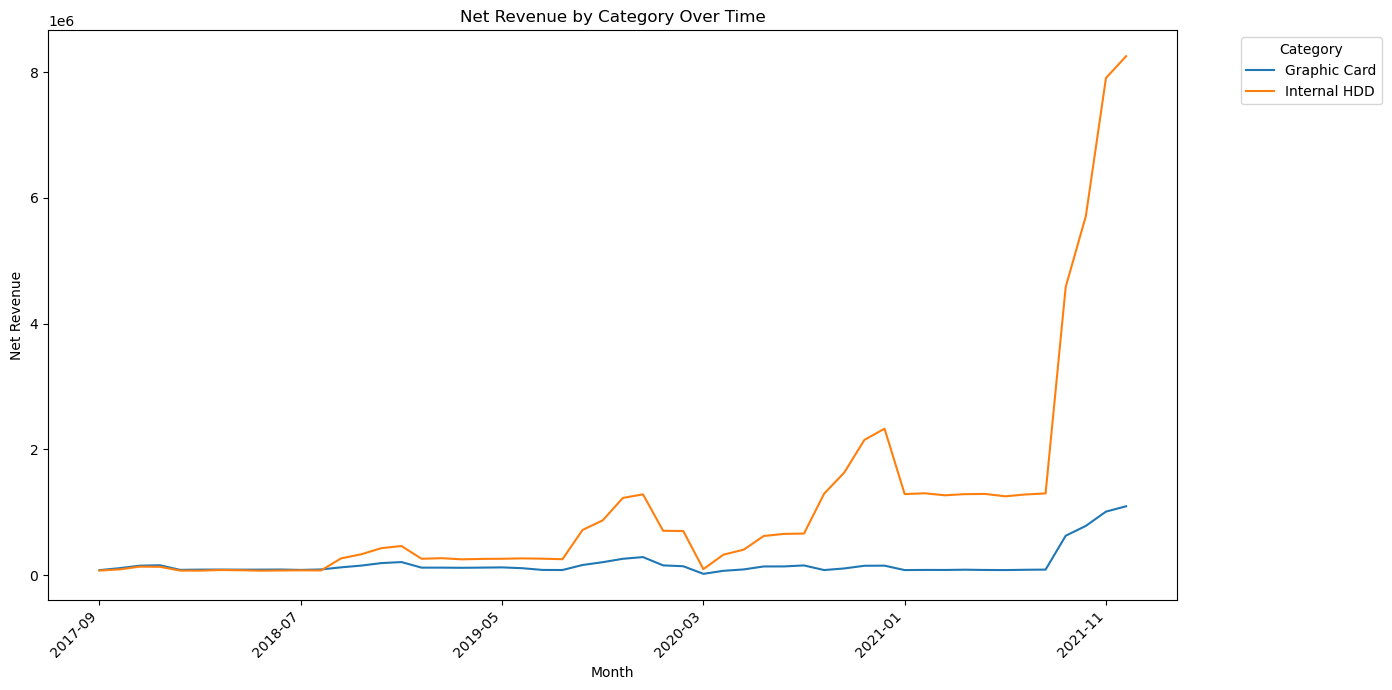

In [93]:
# Plotting net revenue by product category
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Net Revenue by Category Over Time')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [110]:
# Pivot the DataFrame so each category is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='category', values='cumulative_net_revenue')
df_pivot = df_pivot.fillna(0)

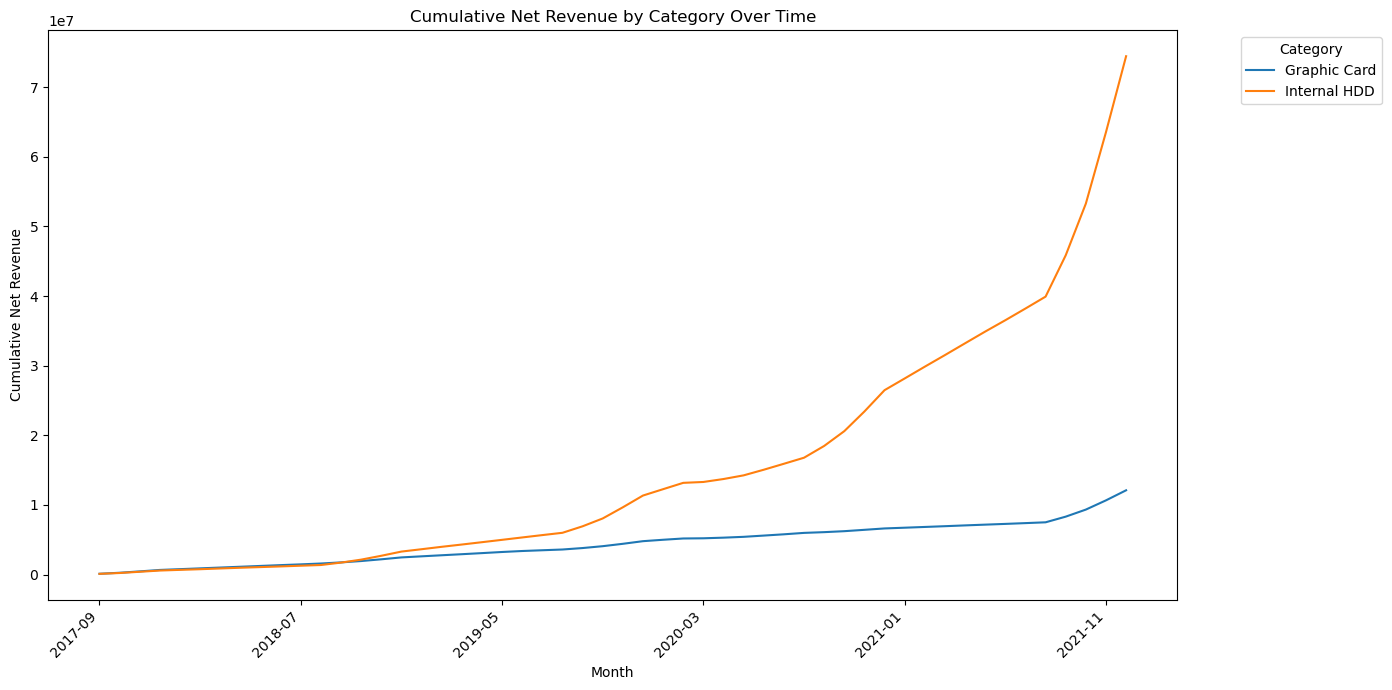

In [108]:
# Plotting cumulative net revenue by product category
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Cumulative Net Revenue by Category Over Time')
plt.xlabel('Month')
plt.ylabel('Cumulative Net Revenue')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Among all categories only 2 were actually sold: graphic card, and internal HDD.  
Looking at all last 3 plots we can say that:
- Internal HDD is the clear revenue leader for most of the observed period. Its gross revenue significantly exceeds that of Graphic Card throughout the timeline.
- Graphic Card revenue appears relatively stable, with modest, gradual growth and minor fluctuations.
- Internal HDD shows much greater volatility, with notable revenue spikes and dips. Especially towards the end of the timeline, there is a dramatic increase.
- There is a sharp and unusual spike in Internal HDD revenue in the most recent months. This pattern is not present in Graphic Card revenue, suggesting a category-specific event.
- Graphic Card category underperforms compared to Internal HDD.

In [113]:
# Finding the product codes that were sold
query = """SELECT 
    product_code, 
    SUM(sold_quantity) AS total_sold_quantity
    FROM fact_sales_monthly
    WHERE sold_quantity > 0
    GROUP BY product_code;
"""
df_product_sum = pd.read_sql_query(query, con)
df_product_sum

,product_code,total_sold_quantity
0,A0118150101,222942
1,A0118150102,221924
2,A0118150103,380146
3,A0118150104,386569
4,A0219150201,378195
5,A0219150202,370148
6,A0220150203,327011
7,A0320150301,319568
8,A0321150302,268082
9,A0321150303,255814


In [6]:
# finding the categories of sold products
query = """SELECT 
    fsm.product_code,
    dp.category,
    dp.product,
    dp.variant,
    SUM(fsm.sold_quantity) AS total_sold_quantity
FROM fact_sales_monthly fsm
JOIN dim_product dp
    ON fsm.product_code = dp.product_code
WHERE fsm.sold_quantity > 0
GROUP BY fsm.product_code, dp.category, dp.product
ORDER BY total_sold_quantity DESC;
"""
df_product = pd.read_sql_query(query, con)
df_product.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\Quantity_by_product.csv', index=False)
df_product

,product_code,category,product,variant,total_sold_quantity
0,A0418150103,Graphic Card,AQ Mforce Gen X,Standard 3,399751
1,A0118150104,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus,386569
2,A0118150103,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium,380146
3,A0219150201,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard,378195
4,A0219150202,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Plus,370148
5,A0220150203,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium,327011
6,A0320150301,Internal HDD,AQ Zion Saga,Standard,319568
7,A0321150302,Internal HDD,AQ Zion Saga,Plus,268082
8,A0321150303,Internal HDD,AQ Zion Saga,Premium,255814
9,A0118150101,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,222942


- 4 different products were sold.
- Each prodact has different variants (standard-premium plus).
- AQ Mforce Gen X is the only sold product in the Graphic Card	category, while in internal HDD category there are 3 prodducts.
- I will reffer to the 4 products by name, ignoring the variants.

In [116]:
# Creating a joined table of metrics by product (name)
query = """SELECT
    month,
    product,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY product ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY product ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY product ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dp.product,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_product dp
      ON fsm.product_code = dp.product_code
    GROUP BY month, dp.product
)
ORDER BY product, month;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,product,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,96766.5191,73323.720440,28935.0108,73323.720440,96766.5191,28935.0108,224.231561,5237,14.001092
1,2017-10,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,119582.5550,92464.906976,35688.6057,165788.627416,216349.0741,64623.6165,307.192382,6472,14.286914
2,2017-11,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,178065.6140,135799.337791,53151.6389,301587.965207,394414.6881,117775.2554,455.702476,9642,14.084146
3,2017-12,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,176992.1172,133262.427689,53019.5034,434850.392896,571406.8053,170794.7588,450.210904,9572,13.922109
4,2018-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,96970.7718,73386.440616,28875.3518,508236.833511,668377.5771,199670.1106,251.323427,5223,14.050630


In [114]:
# Pivot the DataFrame so each product is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='product', values='cumulative_net_revenue')
df_pivot = df_pivot.fillna(0)

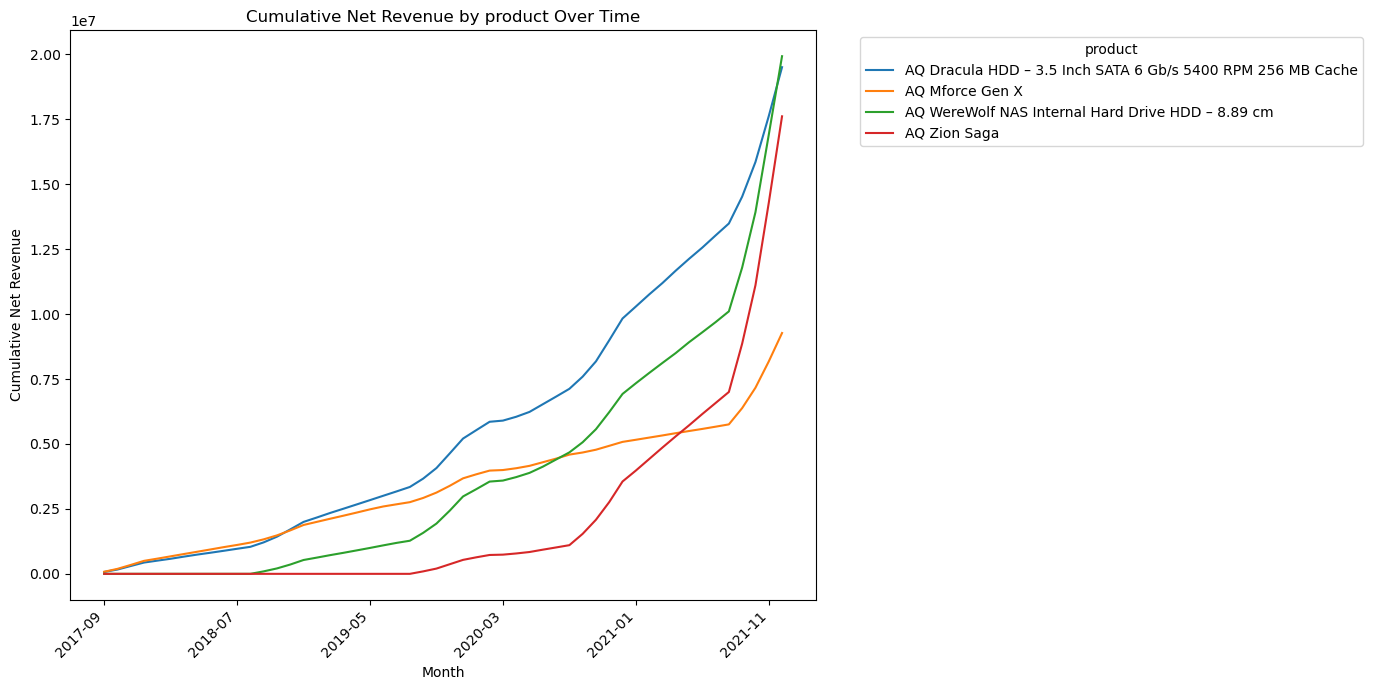

In [115]:
# Plotting cumulative net revenue by product
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Cumulative Net Revenue by product Over Time')
plt.xlabel('Month')
plt.ylabel('Cumulative Net Revenue')
plt.legend(title='product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- All four products show a consistent upward trend in cumulative net revenue, indicating ongoing sales growth over time.
- AQ Dracula HDD is the absolute leader, with the highest cumulative net revenue.
- AQ WereWolf NAS accelerates sharply after mid-2021, nearly catching up with AQ Dracula HDD.
- AQ Zion Saga starts slow but shows a remarkable acceleration in revenue after 2021, rapidly closing the gap with the leading products.
- AQ Mforce Gen X initially keeps pace with the leaders but plateaus in the final months, falling significantly behind the others.
- The lines generally diverge more sharply after 2020, implying an inflection point in the market or company strategy (e.g., post-pandemic demand).

In [118]:
# Pivot the DataFrame so each category is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='product', values='cumulative_gross_man')
df_pivot = df_pivot.fillna(0)

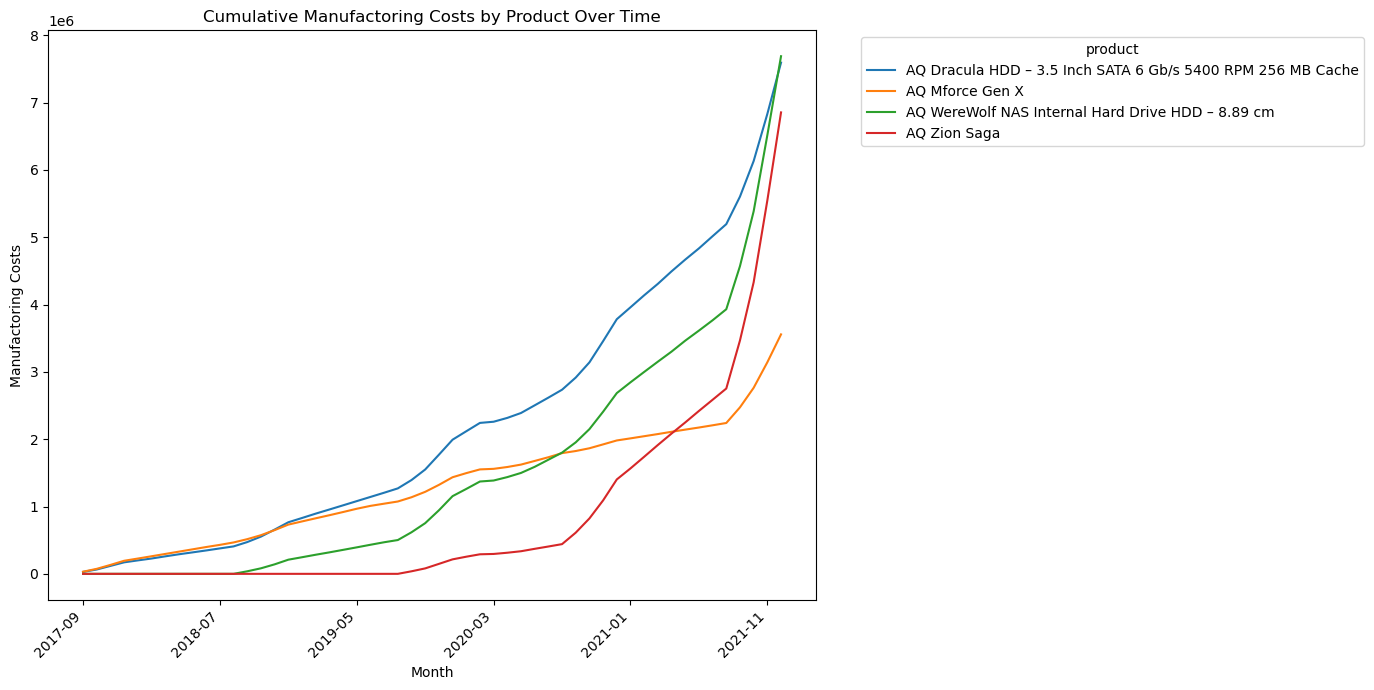

In [119]:
# Plotting cumulative Manufactoring Costs by product 
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Cumulative Manufactoring Costs by Product Over Time')
plt.xlabel('Month')
plt.ylabel('Manufactoring Costs')
plt.legend(title='product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- All four products display a steady increase in cumulative manufacturing costs over time, reflecting ongoing production and sales.
- AQ Dracula HDD has the highest total manufacturing cost by the end of the period.
- AQ WereWolf NAS Internal Hard Drive HDD and AQ Zion Saga show a rapid rise in costs after 2021, mirroring their recent revenue acceleration.
- AQ Mforce Gen X has the lowest total manufacturing cost among the group at the end of the period and its growth rate slows in the last months, confirming the earlier observation of plateauing revenue.
- This plot matches the revenue trend: high costs paired with high revenue suggest large volume sales, not just increased manufacturing expense.

In [6]:
# Creating a joined table of metrics by product (name)--- adding manufactoring cost per item
query = """SELECT
    month,
    product,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY product ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY product ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY product ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item,
    manufactoring_cost_per_unit
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dp.product,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) * 1.0 /
            SUM(fsm.sold_quantity) AS manufactoring_cost_per_unit
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_product dp
      ON fsm.product_code = dp.product_code
    GROUP BY month, dp.product
)
ORDER BY product, month;
"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\Metrics_by_product.csv', index=False)
df_monthly.head()

,month,product,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item,manufactoring_cost_per_unit
0,2017-09,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,96766.5191,73323.720440,28935.0108,73323.720440,96766.5191,28935.0108,224.231561,5237,14.001092,5.525112
1,2017-10,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,119582.5550,92464.906976,35688.6057,165788.627416,216349.0741,64623.6165,307.192382,6472,14.286914,5.514309
2,2017-11,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,178065.6140,135799.337791,53151.6389,301587.965207,394414.6881,117775.2554,455.702476,9642,14.084146,5.512512
3,2017-12,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,176992.1172,133262.427689,53019.5034,434850.392896,571406.8053,170794.7588,450.210904,9572,13.922109,5.539020
4,2018-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,96970.7718,73386.440616,28875.3518,508236.833511,668377.5771,199670.1106,251.323427,5223,14.050630,5.528499


In [116]:
# Pivot the DataFrame so each category is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='product', values='manufactoring_cost_per_unit')
df_pivot = df_pivot.fillna(0)

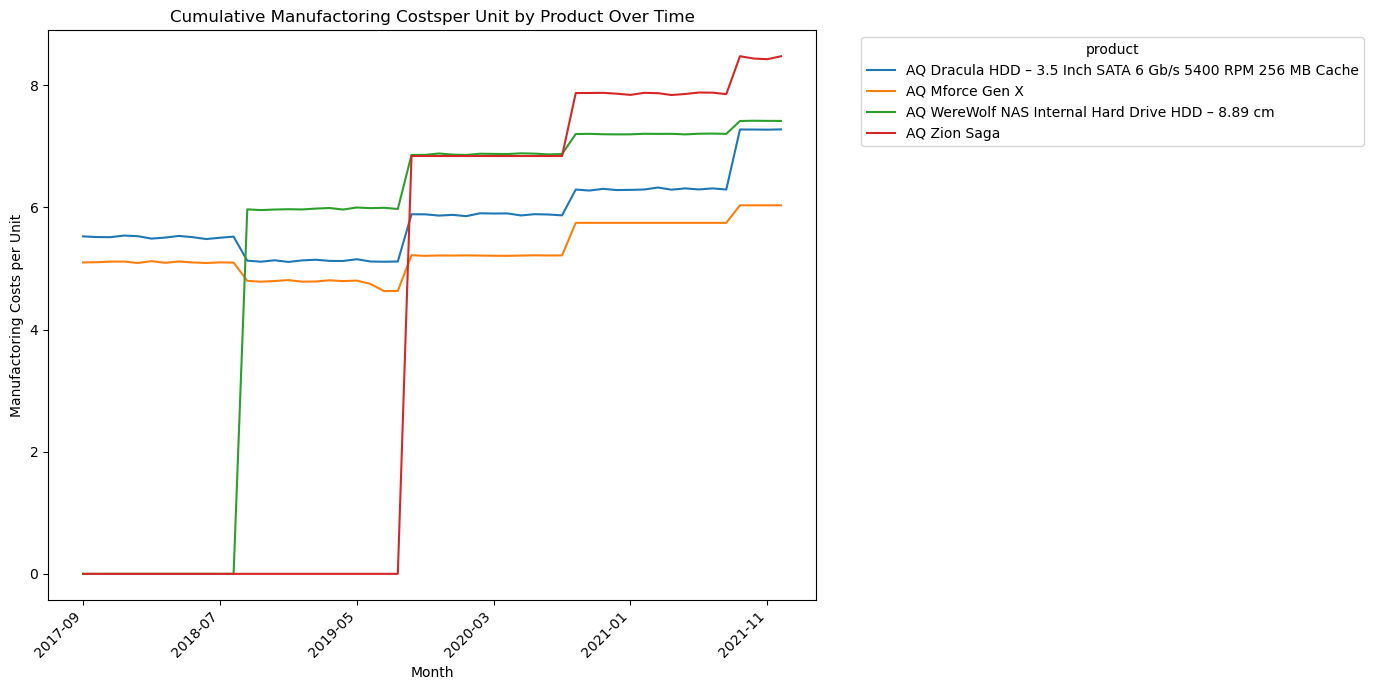

In [117]:
# Plotting cumulative Manufactoring Costs per Unit by product 
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Cumulative Manufactoring Costsper Unit by Product Over Time')
plt.xlabel('Month')
plt.ylabel('Manufactoring Costs per Unit')
plt.legend(title='product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- For most products, the cost per unit is relatively stable over time, but with noticeable “steps” or sudden changes rather than smooth trends. These steps likely correspond to periodic changes in manufacturing cost or adjustments in product specifications, not gradual cost evolution.
- AQ Mforce Gen X Consistently the lowest manufacturing cost per unit, making it potentially the most cost-efficient product to produce.
- AQ Dracula HDD is Slightly higher per-unit cost than Mforce Gen X, but also quite stable with modest increases.
- AQ WereWolf NAS Has a higher cost per unit than the above two, with a visible cost jump after launch, then a stable period, and a late increase.
- AQ Zion Saga Shows the largest increase in per-unit cost (especially after 2021), ending up as the most expensive to manufacture per unit.
- Some lines start after the rest (e.g., WereWolf NAS and Zion Saga), indicating these products were introduced later and have no manufacturing cost recorded until their launch date.

## Metrics by Market

In [55]:
# Creating a joined table of metrics by customer
query = """SELECT
    month,
    customer_code,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY customer_code ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY customer_code ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY customer_code ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dc.customer_code,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_customer dc
      ON fsm.customer_code = dc.customer_code
    GROUP BY month, dc.customer_code
)
ORDER BY customer_code, month;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,customer_code,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,70002017,6270.5375,5753.845210,1862.7986,5753.845210,6270.5375,1862.7986,719.230651,350,16.439558
1,2017-10,70002017,8887.6114,8155.272221,2630.6269,13909.117431,15158.1489,4493.4255,1019.409028,501,16.277988
2,2017-11,70002017,9456.1921,8677.001871,2809.7240,22586.119302,24614.3410,7303.1495,1084.625234,519,16.718693
3,2018-01,70002017,6475.6302,5942.038272,1929.2485,28528.157573,31089.9712,9232.3980,742.754784,363,16.369251
4,2018-02,70002017,7076.1329,6493.059549,2110.3315,35021.217122,38166.1041,11342.7295,811.632444,394,16.479847


In [59]:
# Pivot the DataFrame so each category is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='customer_code', values='net_revenue')
df_pivot = df_pivot.fillna(0)

C:\Users\Daiana\AppData\Local\Temp\ipykernel_7128\1499252829.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


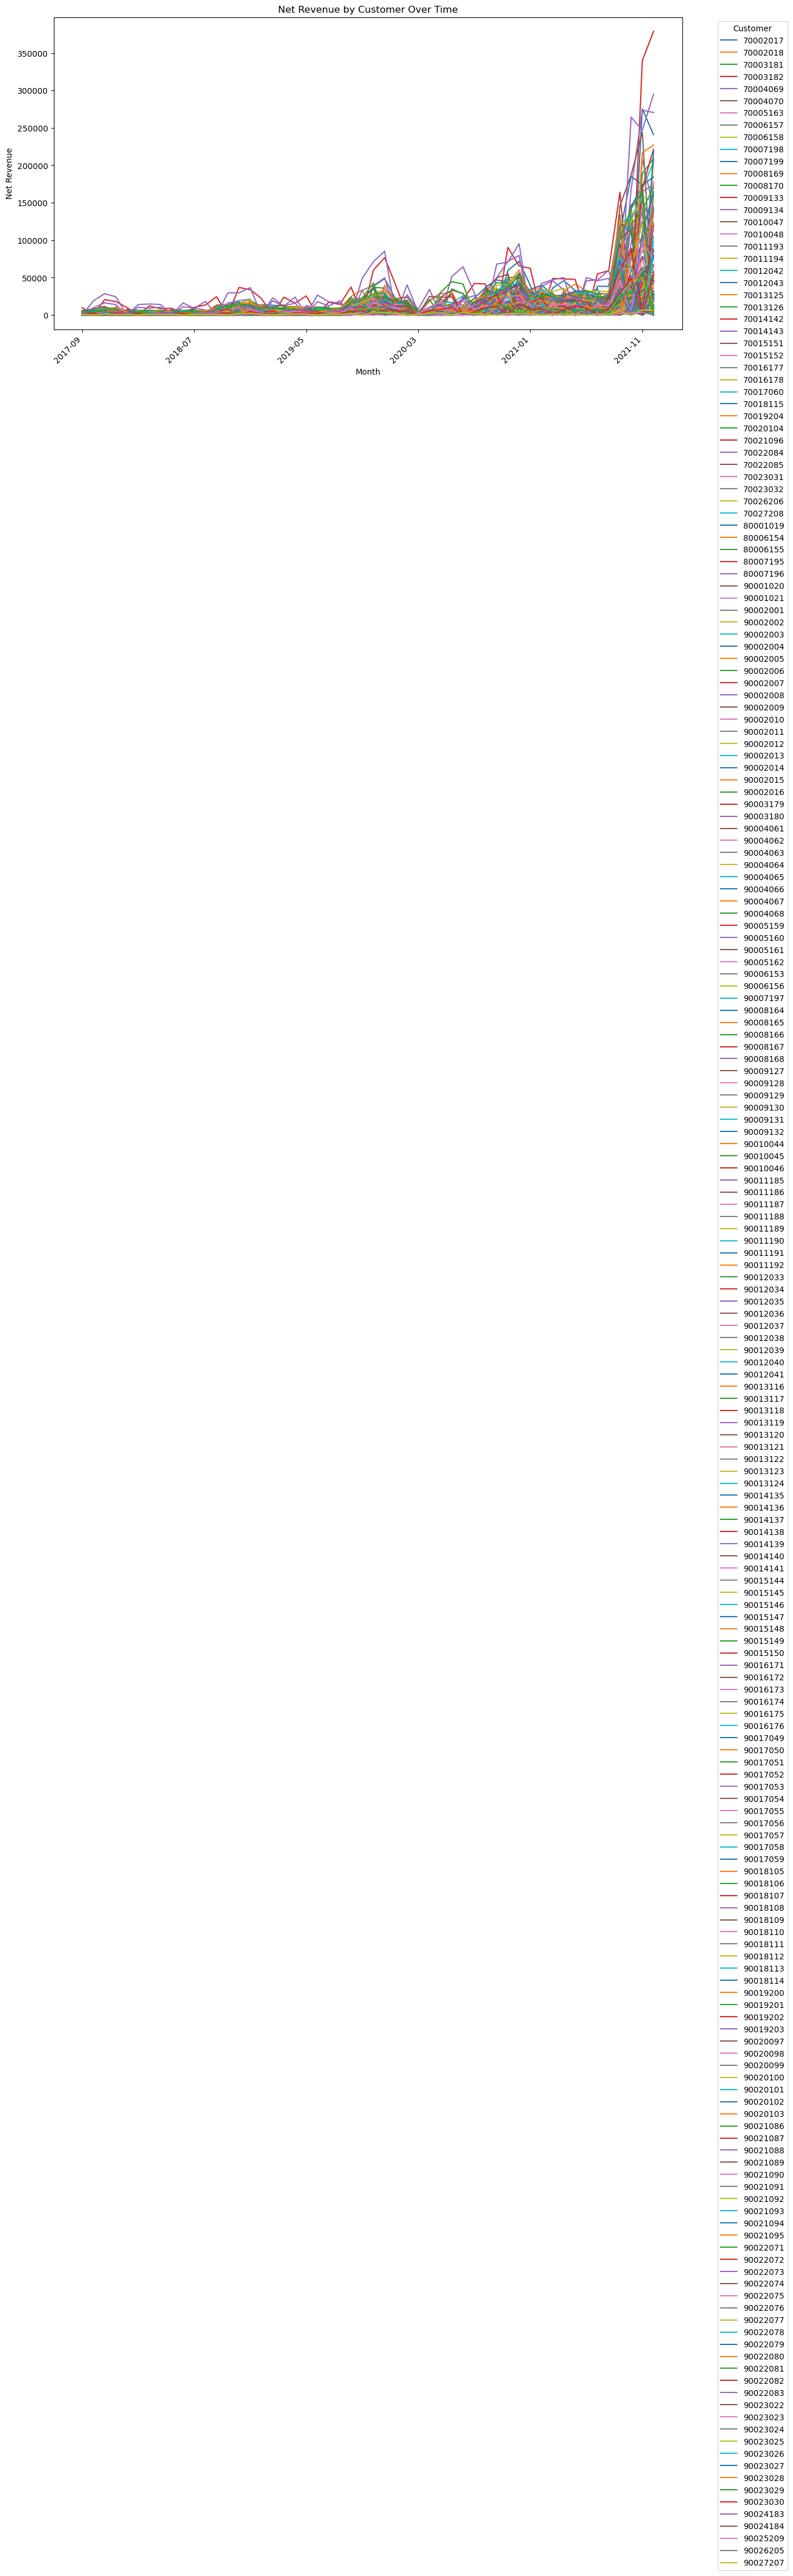

In [61]:
# Plotting net revenue by Customer
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Net Revenue by Customer Over Time')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Too many lines to analyze.

In [24]:
# Creating a joined table of metrics by customer (name)
query = """SELECT
    month,
    customer,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY customer ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY customer ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY customer ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dc.customer,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_customer dc
      ON fsm.customer_code = dc.customer_code
    GROUP BY month, dc.customer
)
ORDER BY customer, month;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,customer,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,Acclaimed Stores,5221.2341,4174.305974,1551.3146,4174.305974,5221.2341,1551.3146,260.894123,289,14.443965
1,2017-11,Acclaimed Stores,10993.5278,8792.109003,3266.9169,12966.414978,16214.7619,4818.2315,549.506813,618,14.226714
2,2017-12,Acclaimed Stores,11247.2891,9003.716456,3335.0468,21970.131434,27462.0510,8153.2783,562.732279,642,14.024480
3,2018-01,Acclaimed Stores,4970.3217,3962.238663,1468.4612,25932.370096,32432.3727,9621.7395,247.639916,280,14.150852
4,2018-03,Acclaimed Stores,5742.9407,4582.835605,1710.3854,30515.205701,38175.3134,11332.1249,286.427225,324,14.144554


In [25]:
# Pivot the DataFrame so each customer is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='customer', values='net_revenue')
df_pivot = df_pivot.fillna(0)

C:\Users\Daiana\AppData\Local\Temp\ipykernel_25060\3440962070.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


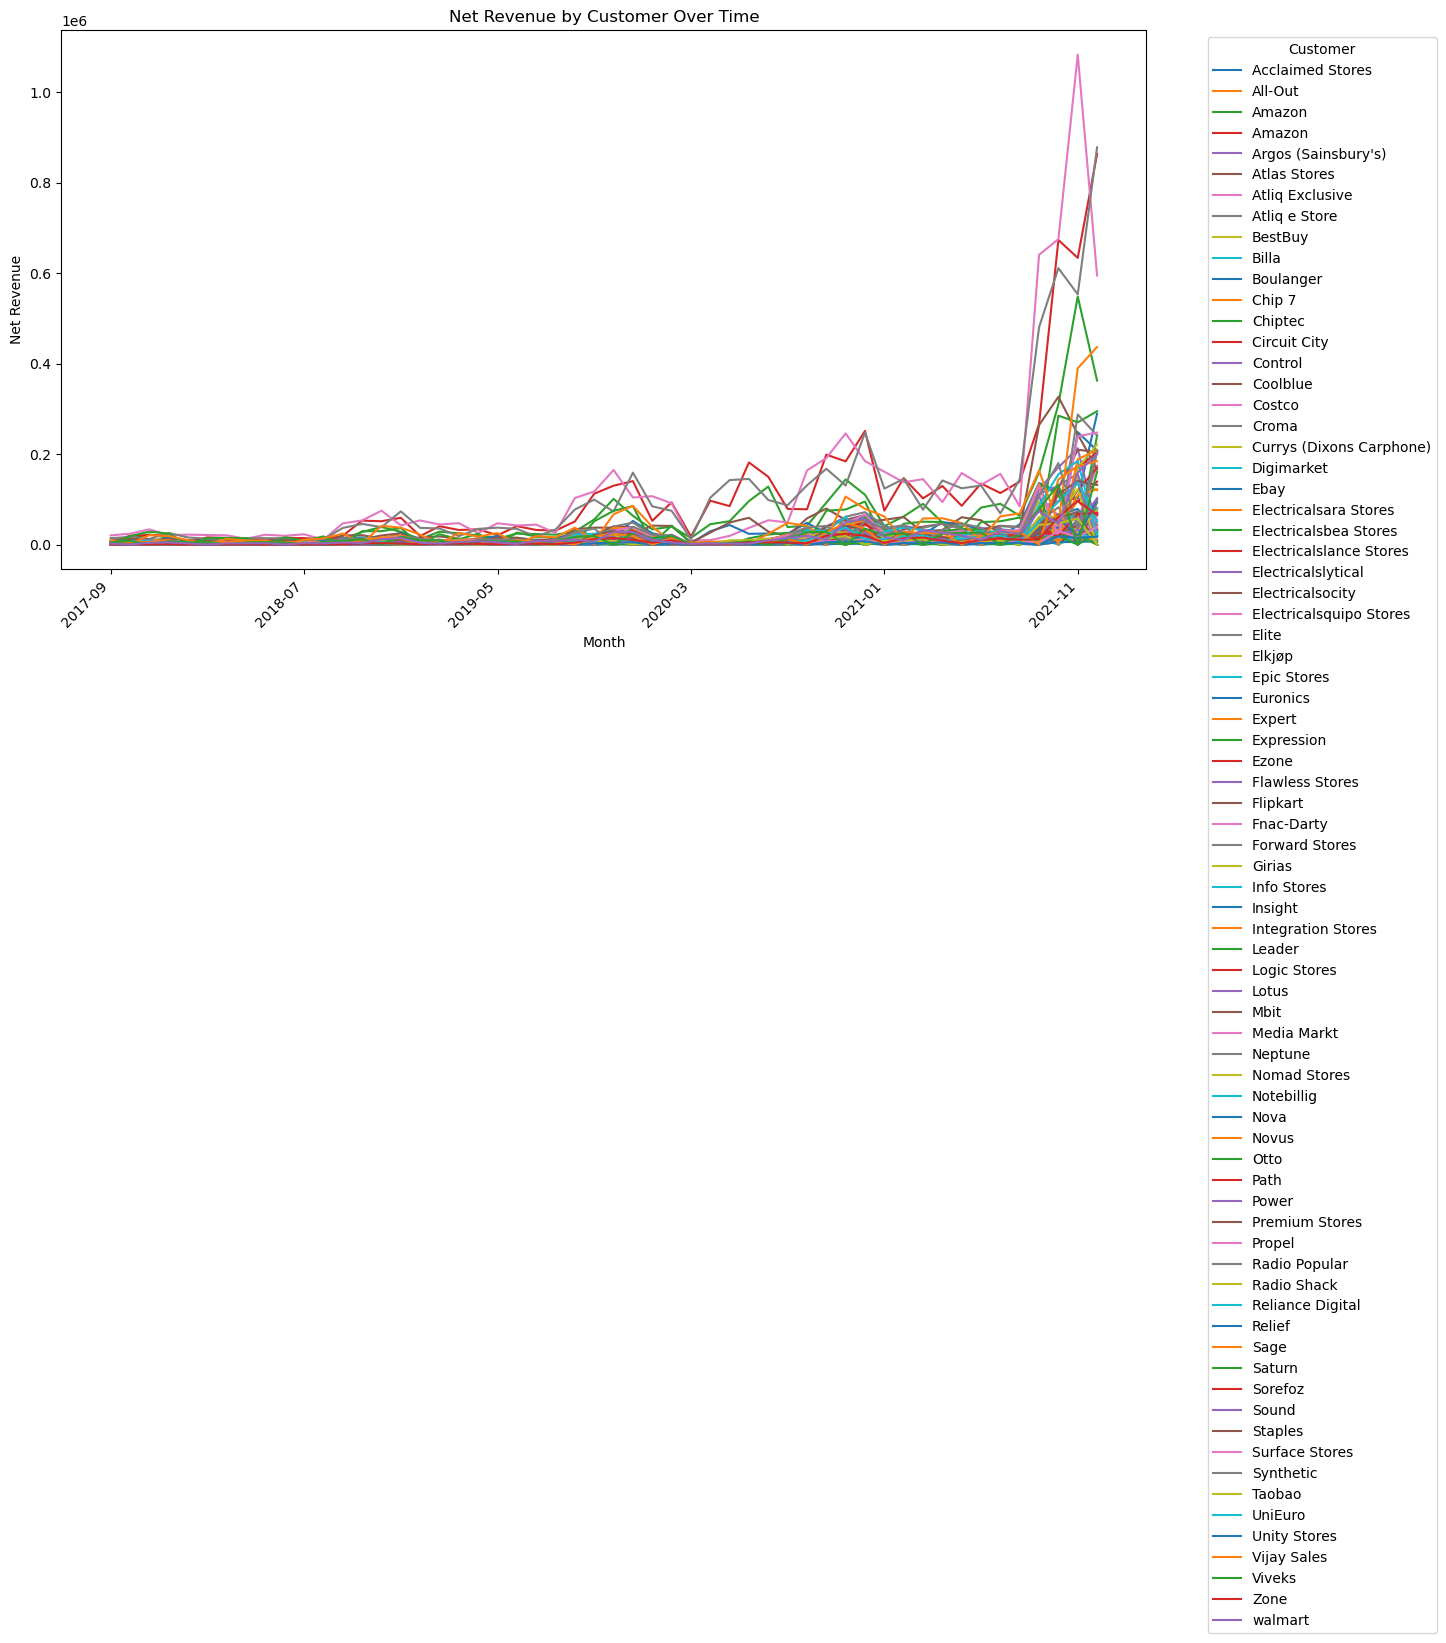

In [26]:
# Plotting net revenue by customer
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Net Revenue by Customer Over Time')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Too many lines to analyze.

<b>See plot below:</b>

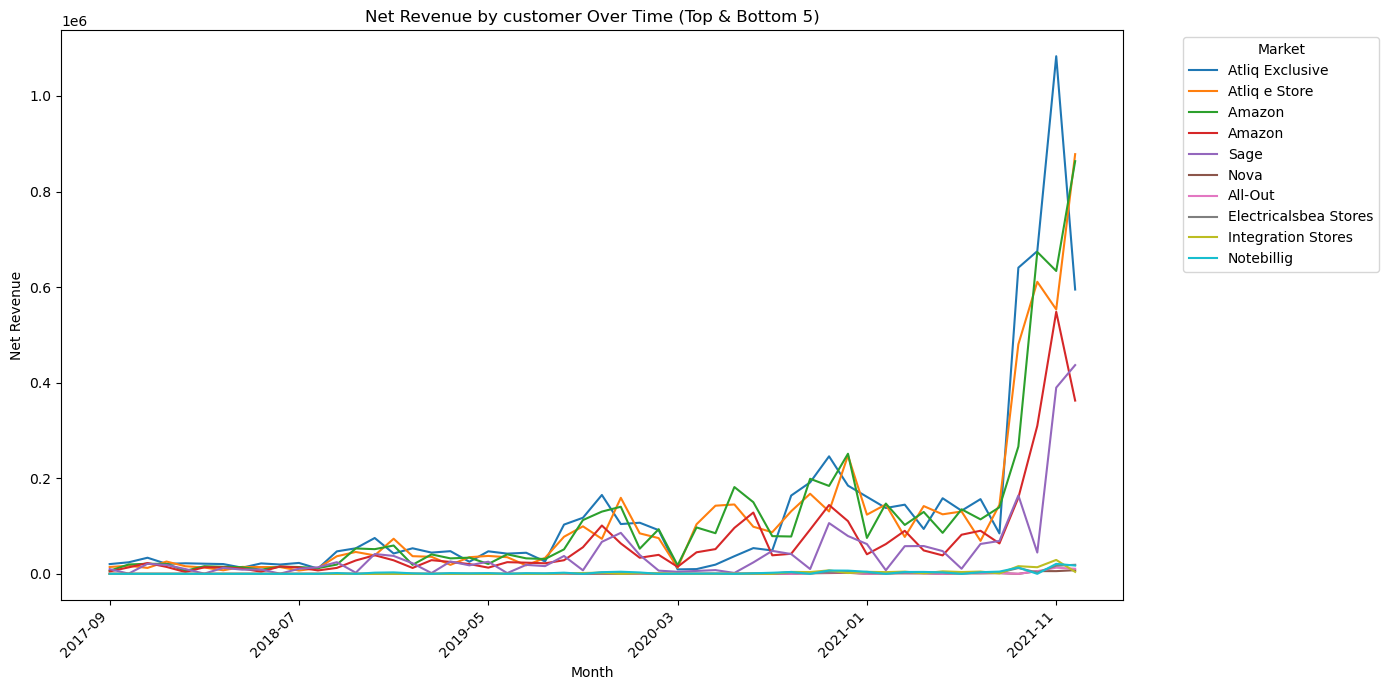

In [27]:
## Ploting only the top and bottom 5 customers
# 1. Calculate total net revenue per customer
total_by_customer = df_pivot.sum()

# 2. Find top 5 and bottom 5 customers by total revenue
top_5_customers = total_by_customer.nlargest(5).index
bottom_5_customers = total_by_customer.nsmallest(5).index

# 3. Combine top and bottom customers (without duplicates)
selected_customers = list(top_5_customers) + [m for m in bottom_5_customers if m not in top_5_customers]

# 4. Subset df_pivot to only these customers
df_selected = df_pivot[selected_customers]

# 5. Plot top and bottom 5 customers
plt.figure(figsize=(14, 7))
df_selected.plot(ax=plt.gca())
plt.title('Net Revenue by customer Over Time (Top & Bottom 5)')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='Market', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [67]:
# Creating a joined table of metrics by platform
query = """SELECT
    month,
    platform,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY platform ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY platform ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY platform ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dc.platform,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_customer dc
      ON fsm.customer_code = dc.customer_code
    GROUP BY month, dc.platform
)
ORDER BY platform, month;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,platform,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,Brick & Mortar,147032.5646,111152.999089,43705.3909,111152.999089,1.470326e+05,43705.3909,230.607882,8245,13.481261
1,2017-10,Brick & Mortar,173967.2495,135250.406675,51579.8382,246403.405764,3.209998e+05,95285.2291,343.275144,9755,13.864726
2,2017-11,Brick & Mortar,280275.2313,214554.584256,83126.1942,460957.990020,6.012750e+05,178411.4233,482.145133,15699,13.666768
3,2017-12,Brick & Mortar,274919.6084,207394.236980,81714.1743,668352.227000,8.761947e+05,260125.5976,530.420043,15404,13.463661
4,2018-01,Brick & Mortar,149380.9229,113458.840767,44326.9545,781811.067767,1.025576e+06,304452.5521,263.857769,8390,13.523104


In [68]:
# Pivot the DataFrame so each customer is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='platform', values='net_revenue')
df_pivot = df_pivot.fillna(0)

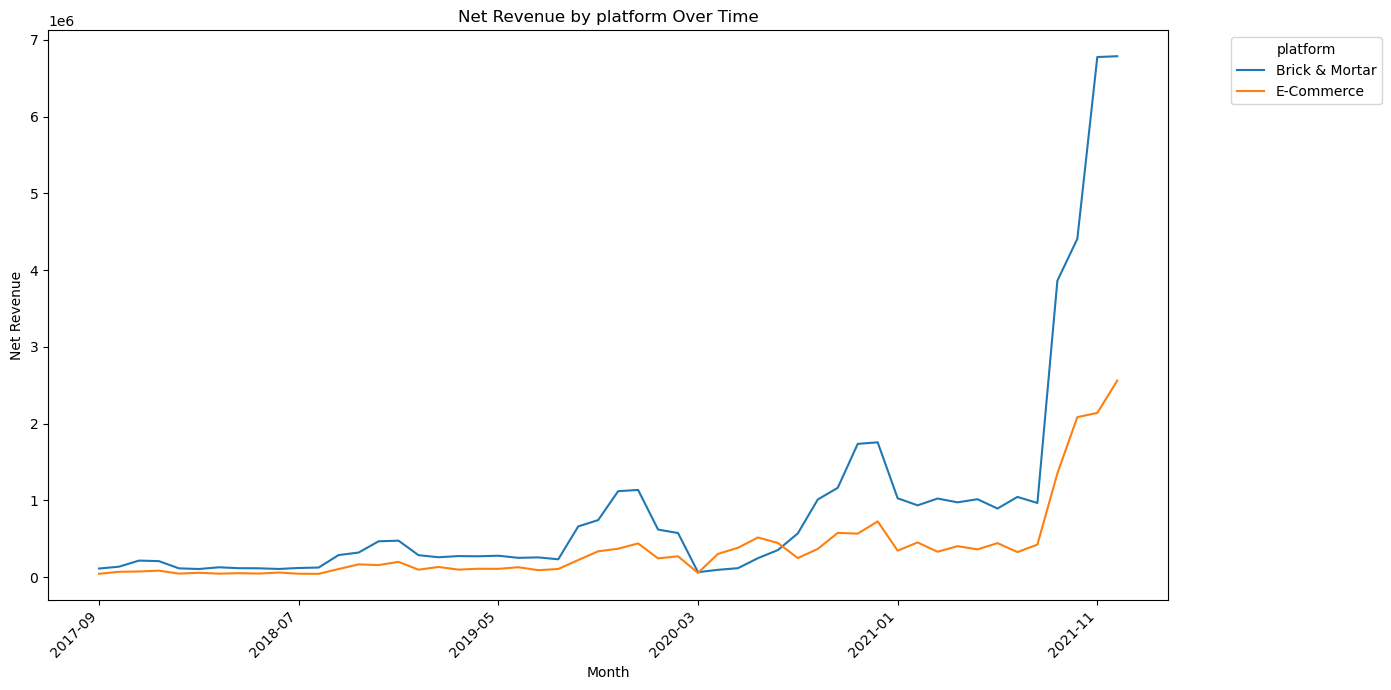

In [69]:
# Plotting net revenue by customer
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Net Revenue by platform Over Time')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Brick & Mortar consistently leads in net revenue compared to E-Commerce throughout the observed period.
- The gap between the two channels remains significant, especially after 2021.
- Both platforms experience a notable acceleration in net revenue after 2021.
- Both Brick & Mortar and E-Commerce show a significant drop in net revenue around early 2020. This period aligns with the onset of the COVID-19 pandemic.

In [70]:
# Creating a joined table of metrics by channel
query = """SELECT
    month,
    channel,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY channel ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY channel ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY channel ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dc.channel,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_customer dc
      ON fsm.customer_code = dc.customer_code
    GROUP BY month, dc.channel
)
ORDER BY channel, month;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,channel,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,Direct,35999.9306,29882.480376,10683.3734,29882.480376,35999.9306,10683.3734,191.554361,2027,14.742220
1,2017-10,Direct,48388.6305,41048.412048,14359.3289,70930.892424,84388.5611,25042.7023,271.843788,2720,15.091328
2,2017-11,Direct,44624.4782,38801.423304,13247.7952,109732.315728,129013.0393,38290.4975,373.090609,2501,15.514364
3,2017-12,Direct,48359.5126,38513.599179,14352.5843,148245.914907,177372.5519,52643.0818,370.323069,2710,14.211660
4,2018-01,Direct,39587.5779,33005.944178,11728.1348,181251.859085,216960.1298,64371.2166,234.084710,2214,14.907834


In [72]:
# Pivot the DataFrame so each channel is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='channel', values='net_revenue')
df_pivot = df_pivot.fillna(0)

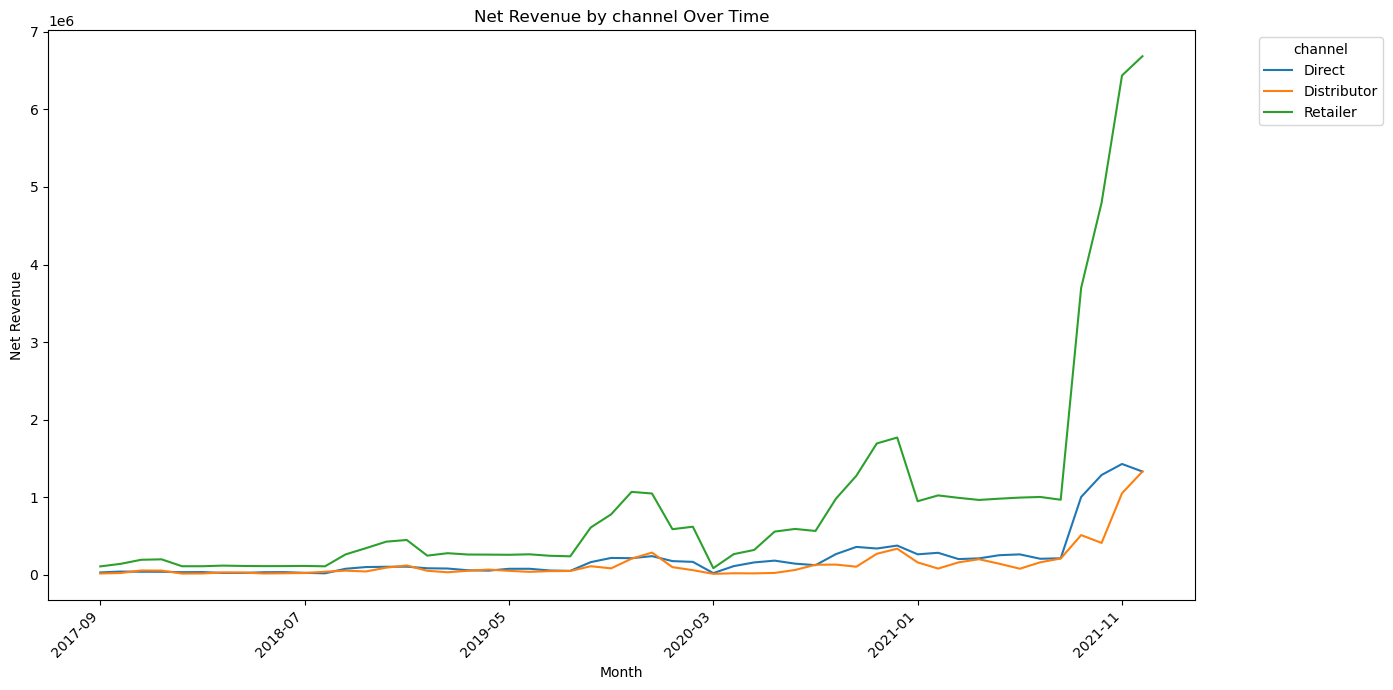

In [73]:
# Plotting net revenue by channel
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Net Revenue by channel Over Time')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Retailer is the leading channel for net revenue, far outpacing both Direct and Distributor channels, especially after 2021.
- The gap widens significantly in the late period, with Retailer net revenue surging upwards.
- Both Direct and Distributor channels have comparable revenue trajectories—relatively flat until late 2021, then increasing, but on a much smaller scale than Retailer.
- Similar to other plots, there is a notable dip in all channels around early 2020 (pandemic onset).
- Retailer channel displays more volatility and periodic spikes than the other channels.
- Direct and Distributor channels are more stable.

In [53]:
# Creating a joined table of metrics by market
query = """SELECT
    month,
    market,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY market ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY market ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY market ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dc.market,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_customer dc
      ON fsm.customer_code = dc.customer_code
    GROUP BY month, dc.market
)
ORDER BY market, month;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\marketss_monthly.csv', index=False)
df_monthly.head()

,month,market,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,Australia,9103.1301,7159.401496,2700.5886,7159.401496,9103.1301,2700.5886,178.985037,513,13.955948
1,2017-10,Australia,16138.6281,12115.083678,4787.2641,19274.485174,25241.7582,7487.8527,252.397577,896,13.521299
2,2017-11,Australia,14741.7272,11289.374278,4378.8112,30563.859452,39983.4854,11866.6639,282.234357,816,13.835017
3,2017-12,Australia,17585.7527,13042.760966,5223.4327,43606.620418,57569.2381,17090.0966,326.069024,990,13.174506
4,2018-01,Australia,9455.1961,7419.758111,2799.4559,51026.378529,67024.4342,19889.5525,185.493953,531,13.973179


In [76]:
# Pivot the DataFrame so each market is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='market', values='net_revenue')
df_pivot = df_pivot.fillna(0)

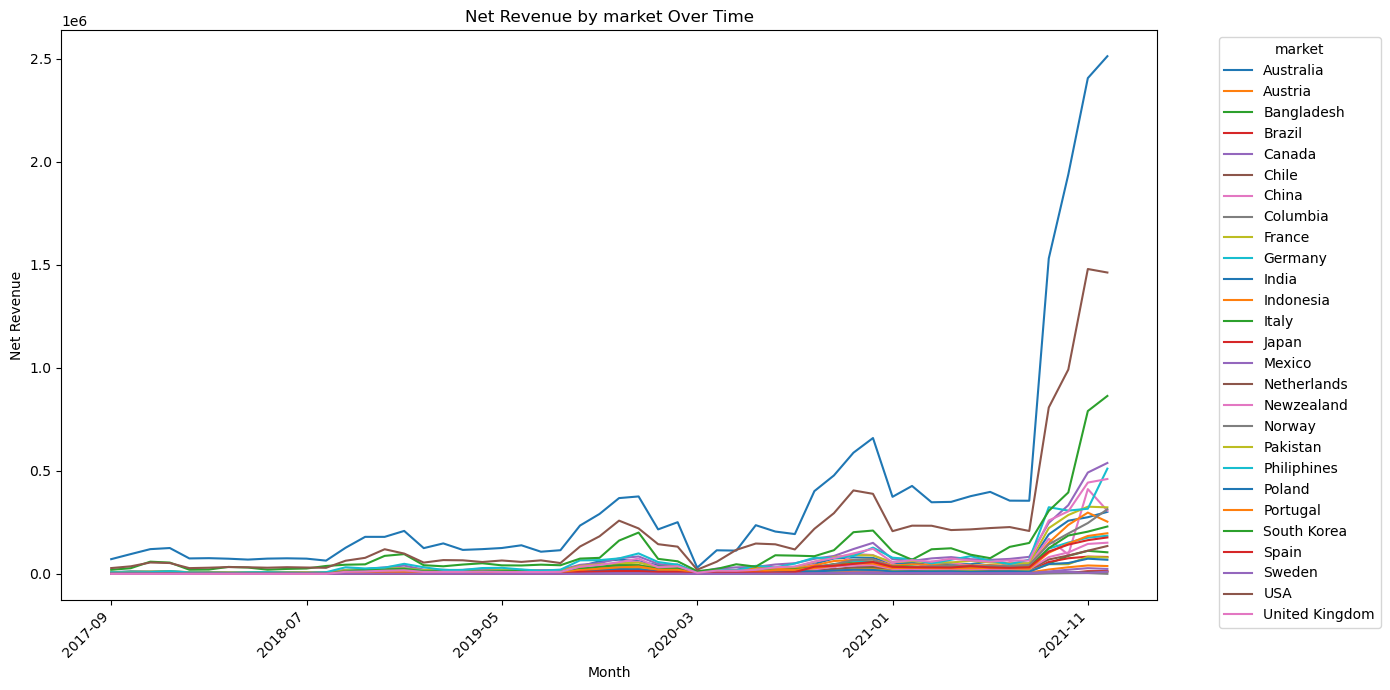

In [77]:
# Plotting net revenue by market
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Net Revenue by market Over Time')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='market', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Too many lines to analyze.  
I will plot the top and bottom 5.

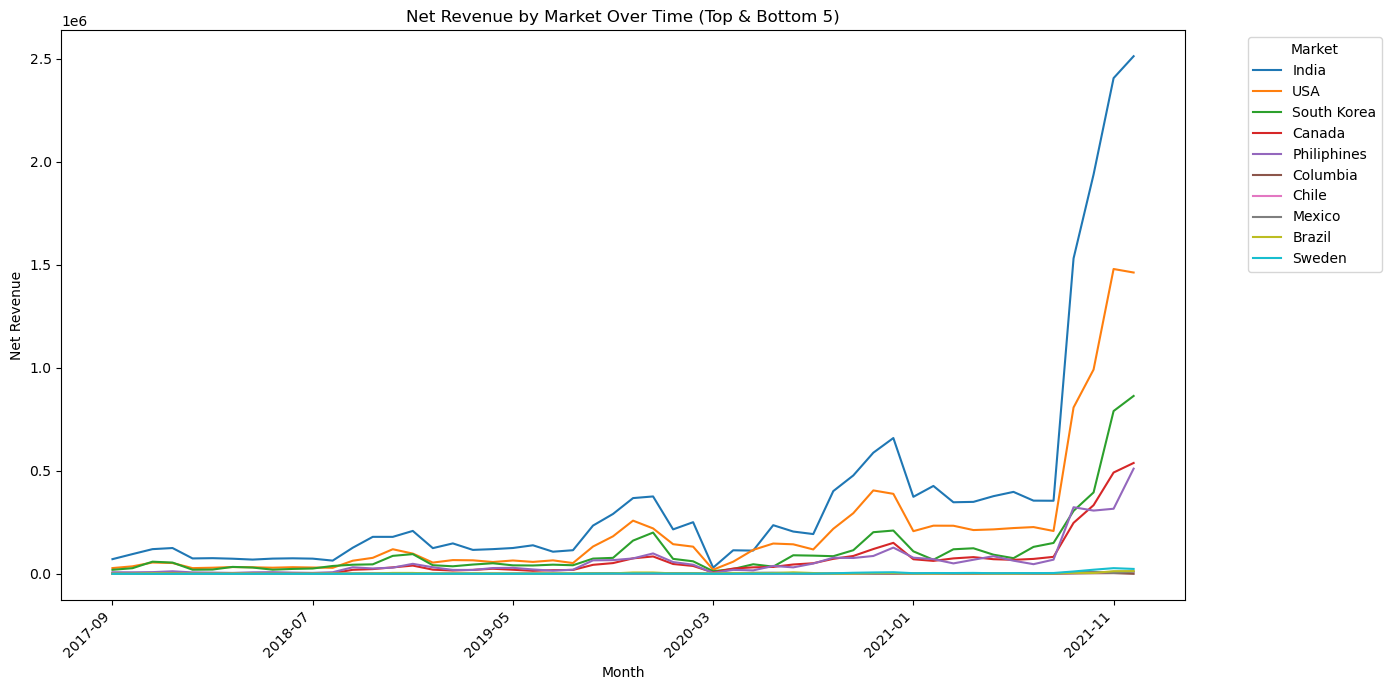

In [78]:
## Ploting only the top and bottom 5 markets
# 1. Calculate total net revenue per market
total_by_market = df_pivot.sum()

# 2. Find top 5 and bottom 5 markets by total revenue
top_5_markets = total_by_market.nlargest(5).index
bottom_5_markets = total_by_market.nsmallest(5).index

# 3. Combine top and bottom markets (without duplicates)
selected_markets = list(top_5_markets) + [m for m in bottom_5_markets if m not in top_5_markets]

# 4. Subset df_pivot to only these markets
df_selected = df_pivot[selected_markets]

# 5. Plot top and bottom 5 markets
plt.figure(figsize=(14, 7))
df_selected.plot(ax=plt.gca())
plt.title('Net Revenue by Market Over Time (Top & Bottom 5)')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='Market', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


- India is the clear market leader, with a dramatic surge in net revenue in the most recent period—outpacing all other markets.
- USA follows as a strong second, also showing a significant late-period revenue spike.
- South Korea exhibits strong growth in the later periods, but at a lower scale compared to India and USA.
- These bottom markets show only modest increases or flat performance, with no late surge similar to top performers.
- A marked jump in revenue across most top markets is visible starting around late 2021.

In [79]:
# Creating a joined table of metrics by sub zone
query = """SELECT
    month,
    sub_zone,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY sub_zone ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY sub_zone ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY sub_zone ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dc.sub_zone,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_customer dc
      ON fsm.customer_code = dc.customer_code
    GROUP BY month, dc.sub_zone
)
ORDER BY sub_zone, month;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,sub_zone,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,ANZ,9103.1301,7159.401496,2700.5886,7159.401496,9103.1301,2700.5886,178.985037,513,13.955948
1,2017-10,ANZ,16138.6281,12115.083678,4787.2641,19274.485174,25241.7582,7487.8527,252.397577,896,13.521299
2,2017-11,ANZ,14741.7272,11289.374278,4378.8112,30563.859452,39983.4854,11866.6639,282.234357,816,13.835017
3,2017-12,ANZ,17585.7527,13042.760966,5223.4327,43606.620418,57569.2381,17090.0966,326.069024,990,13.174506
4,2018-01,ANZ,9455.1961,7419.758111,2799.4559,51026.378529,67024.4342,19889.5525,185.493953,531,13.973179


In [80]:
# Pivot the DataFrame so each sub_zone is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='sub_zone', values='net_revenue')
df_pivot = df_pivot.fillna(0)

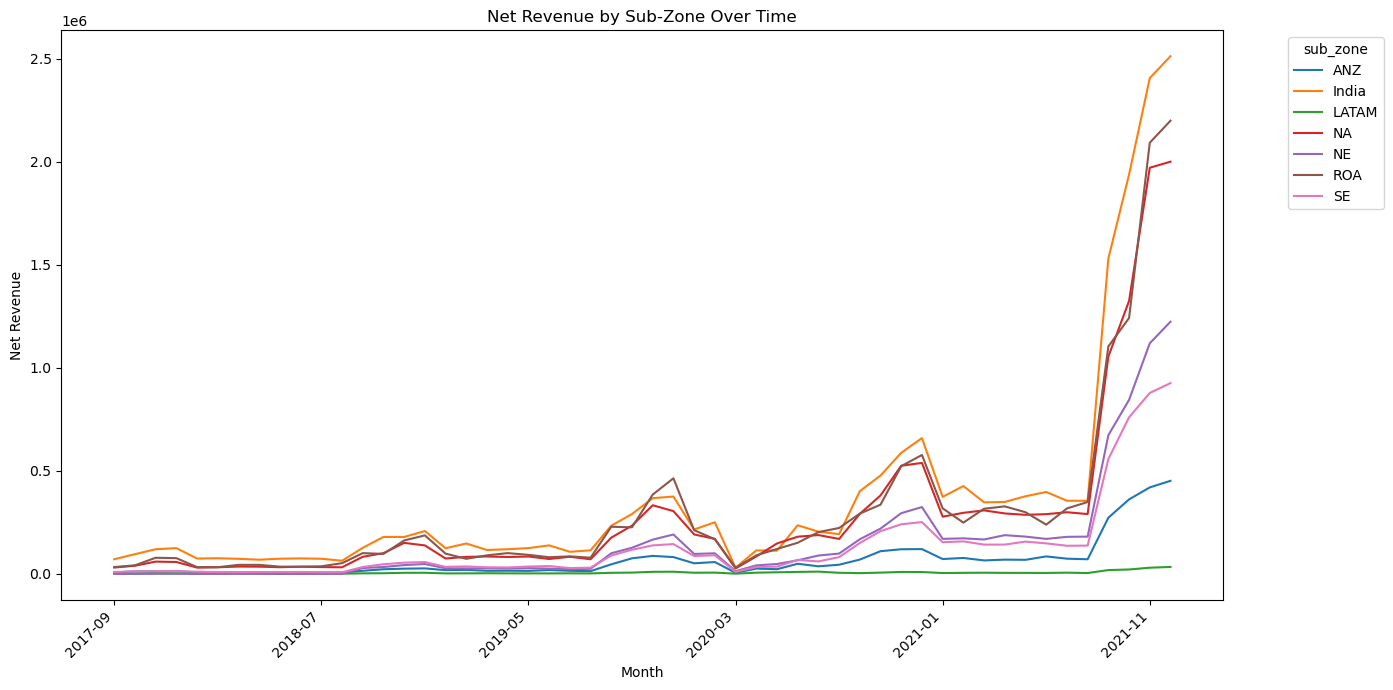

In [81]:
# Plotting net revenue by sub_zone
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Net Revenue by Sub-Zone Over Time')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='sub_zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Is the same as region.

In [82]:
# Creating a joined table of metrics by region
query = """SELECT
    month,
    region,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (PARTITION BY region ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (PARTITION BY region ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (PARTITION BY region ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        dc.region,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    JOIN dim_customer dc
      ON fsm.customer_code = dc.customer_code
    GROUP BY month, dc.region
)
ORDER BY region, month;

"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,region,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,APAC,147534.4559,111775.856900,43850.6689,111775.856900,1.475345e+05,43850.6689,423.393397,8290,13.483216
1,2017-10,APAC,193219.0564,149745.835645,57313.4322,261521.692545,3.407535e+05,101164.1011,567.219074,10829,13.828224
2,2017-11,APAC,274836.6168,209668.537437,81499.1119,471190.229982,6.155901e+05,182663.2130,819.017724,15394,13.620147
3,2017-12,APAC,286135.6703,215025.680752,85108.9312,686215.910734,9.017258e+05,267772.1442,867.039035,16067,13.383063
4,2018-01,APAC,151577.1108,115404.717228,44978.3641,801620.627963,1.053303e+06,312750.5083,437.139080,8495,13.585017


In [80]:
# Pivot the DataFrame so each region is a column, months are the index
df_pivot = df_monthly.pivot(index='month', columns='region', values='net_revenue')
df_pivot = df_pivot.fillna(0)

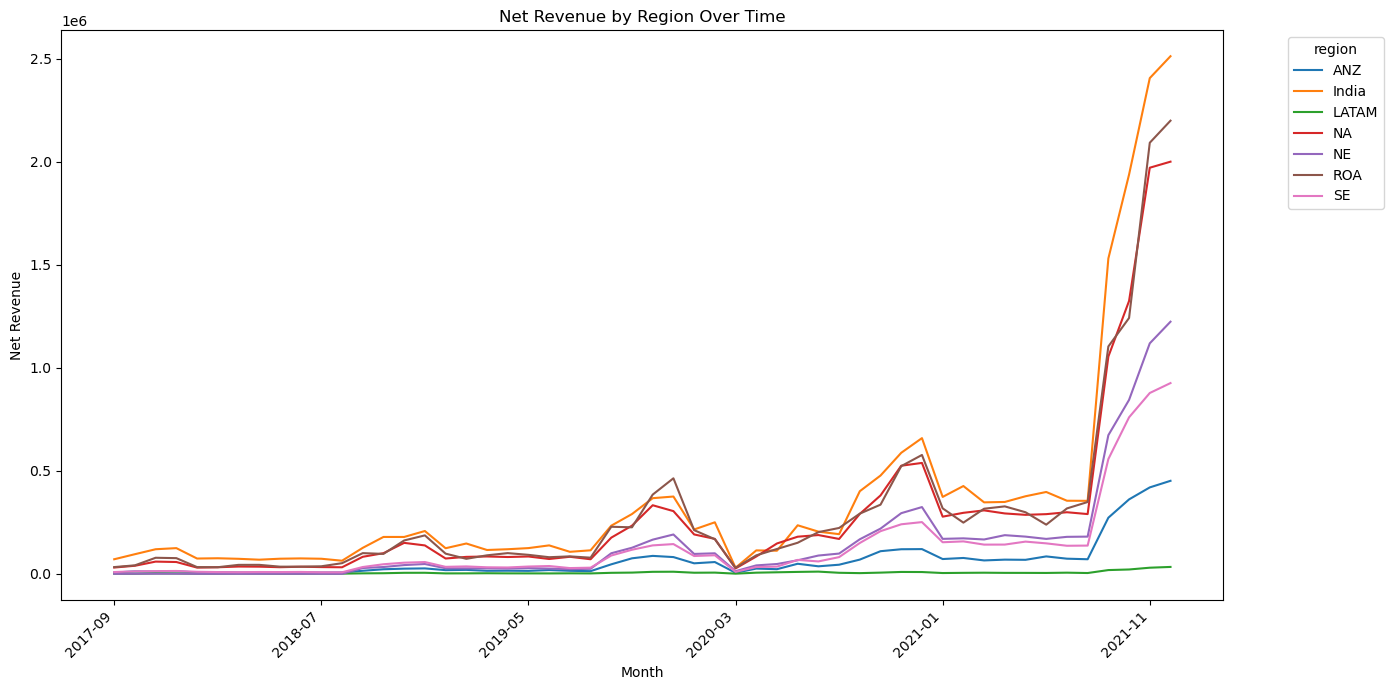

In [83]:
# Plotting net revenue by region
plt.figure(figsize=(14, 7))
df_pivot.plot(ax=plt.gca())
plt.title('Net Revenue by Region Over Time')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.legend(title='region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- India is the strongest region, with the highest net revenue—especially after late 2021, when it experiences a dramatic surge and outpaces all other regions.
- Both NA (North America) and ROA (Rest of Asis) show robust growth, especially after 2021, but remain below India in total net revenue.
- Multiple regions (India, NA, ROA, NE, SE) display a pronounced spike in revenue starting in late 2021.
- LATAM (Latin America) and ANZ (Australia/New Zealand) have much lower net revenues throughout the timeline, with only modest growth.
- All regions show a dip around early 2020 (likely pandemic impact), followed by a strong rebound.

## Hypotheses Testing

In this secction I will test the hypothesis that: costumers that recieve a big discount, will buy more.  
Threshold will be determined by median.  
Metrics: gross and net revenue, items per purchase.

<b>H0: There is no difference between customers the recieve a big discount comparing to customers that recieve a small discount.
</b><br>
<b>H1: Customers the recieve a big discount will buy more, comparing to customers that recieve a small discount.
</b><br>

In [7]:
# Creating a joined table of metrics
query = """SELECT
    fsm.fiscal_year,
    fsm.date,
    fsm.product_code,
    fsm.customer_code,
    fsm.sold_quantity,
    fgp.gross_price,
    (fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS discoun_price,
    fpd.pre_invoice_discount_pct,
    (fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
    (fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
    (fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man

FROM fact_sales_monthly fsm

JOIN fact_gross_price fgp
  ON fsm.product_code = fgp.product_code
 AND fsm.fiscal_year = fgp.fiscal_year

JOIN fact_manufacturing_cost fmc
  ON fsm.product_code = fmc.product_code
  AND fsm.fiscal_year = fmc.cost_year

JOIN fact_pre_discount fpd
  ON fsm.customer_code = fpd.customer_code
 AND fsm.fiscal_year = fpd.fiscal_year;
"""
revenue = pd.read_sql_query(query, con)
revenue.head()

,fiscal_year,date,product_code,customer_code,sold_quantity,gross_price,discoun_price,pre_invoice_discount_pct,gross_revenue,net_revenue,gross_man
0,2018,2017-09-01,A0118150101,70002017,51,15.3952,14.126636,0.0824,785.1552,720.458412,235.569
1,2018,2017-09-01,A0118150101,70002018,77,15.3952,10.844379,0.2956,1185.4304,835.017174,355.663
2,2018,2017-09-01,A0118150101,70003181,17,15.3952,14.570017,0.0536,261.7184,247.690294,78.523
3,2018,2017-09-01,A0118150101,70003182,6,15.3952,11.734221,0.2378,92.3712,70.405329,27.714
4,2018,2017-09-01,A0118150101,70006157,5,15.3952,13.767927,0.1057,76.9760,68.839637,23.095


In [9]:
# finding median for discount
median_discount = revenue['pre_invoice_discount_pct'].median()
median_discount

np.float64(0.2404)

In [12]:
# Label each row by discount pct
revenue['discount_group'] = np.where(
    revenue['pre_invoice_discount_pct'] >= median_discount,
    'Big',
    'Small')
revenue.head(5)

,fiscal_year,date,product_code,customer_code,sold_quantity,gross_price,discoun_price,pre_invoice_discount_pct,gross_revenue,net_revenue,gross_man,discount_group
0,2018,2017-09-01,A0118150101,70002017,51,15.3952,14.126636,0.0824,785.1552,720.458412,235.569,Small
1,2018,2017-09-01,A0118150101,70002018,77,15.3952,10.844379,0.2956,1185.4304,835.017174,355.663,Big
2,2018,2017-09-01,A0118150101,70003181,17,15.3952,14.570017,0.0536,261.7184,247.690294,78.523,Small
3,2018,2017-09-01,A0118150101,70003182,6,15.3952,11.734221,0.2378,92.3712,70.405329,27.714,Small
4,2018,2017-09-01,A0118150101,70006157,5,15.3952,13.767927,0.1057,76.9760,68.839637,23.095,Small


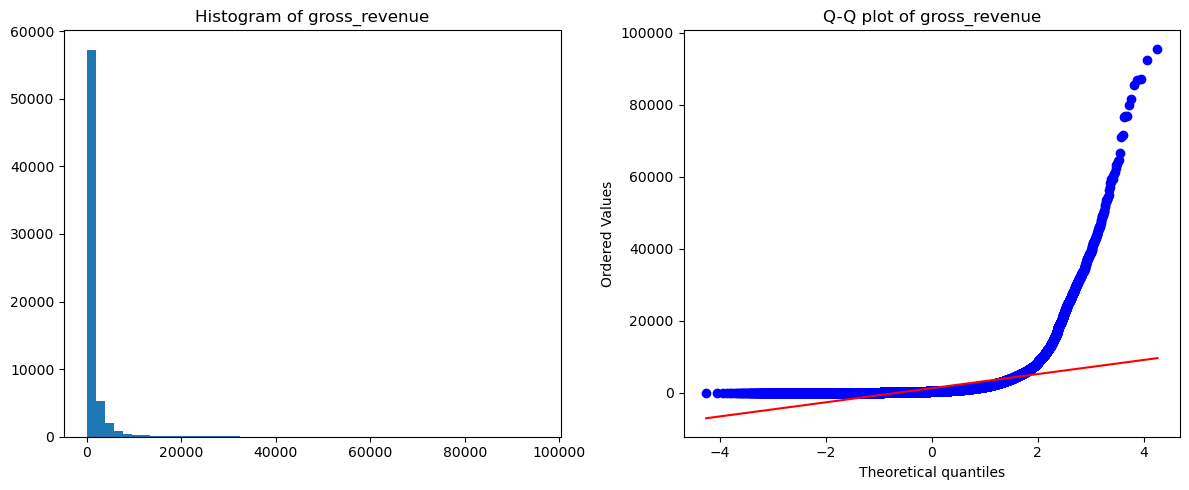

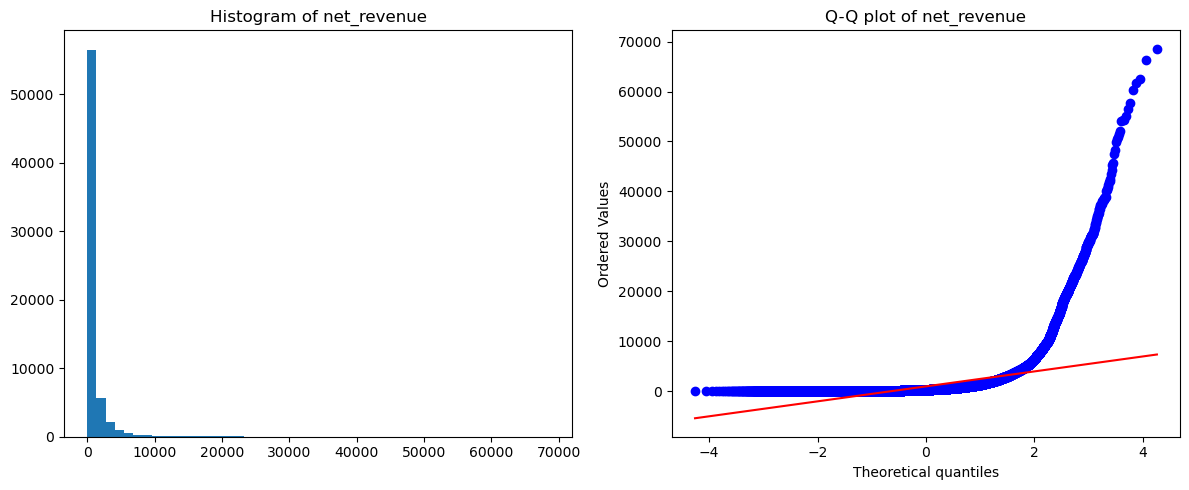

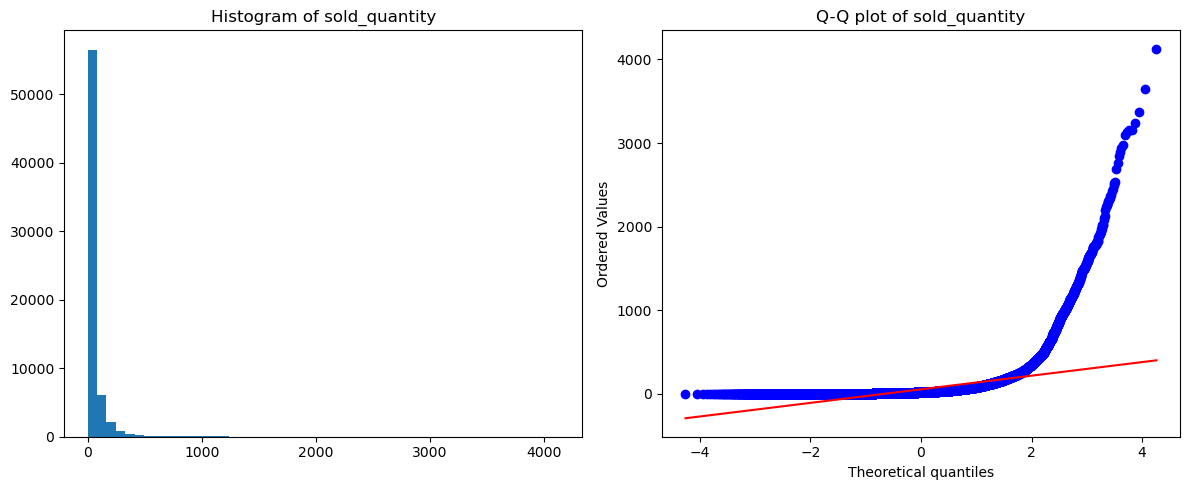

In [14]:
# Ploting metrics
for metric in ['gross_revenue', 'net_revenue', 'sold_quantity']:
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.hist(revenue[metric], bins=50)
    plt.title(f'Histogram of {metric}')

    plt.subplot(1, 2, 2)
    stats.probplot(revenue[metric], dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {metric}')
    
    plt.tight_layout()
    plt.show()


In [17]:
# Normality test
for metric in ['gross_revenue', 'net_revenue', 'sold_quantity']:
    stat, p = shapiro(revenue[metric].sample(5000) if len(revenue[metric]) > 5000 else revenue[metric])
    print(f'{metric}: W={stat:.3f}, p-value={p:.4f}')


gross_revenue: W=0.339, p-value=0.0000
net_revenue: W=0.300, p-value=0.0000
sold_quantity: W=0.373, p-value=0.0000


The metrics do not distribute normally.  
I will use Mann-Whitney.

In [21]:
# Running man-whitney test
big = revenue[revenue['discount_group'] == 'Big']
small = revenue[revenue['discount_group'] == 'Small']

metrics = ['gross_revenue', 'net_revenue', 'sold_quantity']

for metric in metrics:
    print(f"\n--- {metric.upper()} ---")
    u_stat, u_p = mannwhitneyu(big[metric], small[metric], alternative='two-sided')
    print(f"Mann-Whitney U: statistic={u_stat:.3f}, p-value={u_p:.4f}")



--- GROSS_REVENUE ---
Mann-Whitney U: statistic=542258340.500, p-value=0.0000

--- NET_REVENUE ---
Mann-Whitney U: statistic=518266184.000, p-value=0.0000

--- SOLD_QUANTITY ---
Mann-Whitney U: statistic=540686899.000, p-value=0.0000


There is a statistically significant difference between the groups for all three metrics.

In [22]:
# Grouping by discount group to see metrics
grouped = revenue.groupby('discount_group').agg({
    'gross_revenue': 'mean',
    'net_revenue': 'mean',
    'sold_quantity': 'mean'
}).reset_index()
grouped

,discount_group,gross_revenue,net_revenue,sold_quantity
0,Big,1258.372327,908.630006,54.964307
1,Small,1315.868308,1063.720608,57.543248


- The differences between the “Big” and “Small” discount groups are highly statistically significant for all metrics (gross revenue, net revenue, sold quantity).
- Small discount customers actually have higher averages for gross revenue, net revenue, and items per purchase.

Big discounts did NOT lead to buying more—in fact, the opposite.  

Contrary to the initial hypothesis, customers who received larger discounts purchased significantly less, both in revenue and quantity, compared to those who received smaller discounts. All differences were statistically significant (p < 0.001).

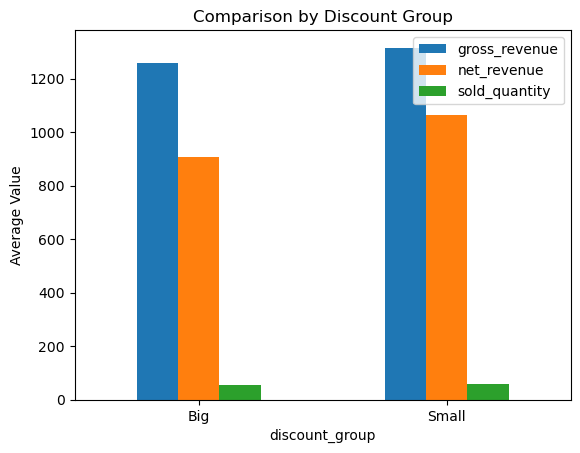

In [23]:
# Ploting metrics by discount group
grouped = revenue.groupby('discount_group').mean(numeric_only=True).loc[['Big', 'Small']]
grouped[['gross_revenue', 'net_revenue', 'sold_quantity']].plot(kind='bar')
plt.title('Comparison by Discount Group')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.show()


## Forecasting metrics

### All period in one moodel (Exponential Smoothing)

In [12]:
# Creating a joined table of metrics by month
query = """SELECT
    month,
    gross_revenue,
    net_revenue,
    gross_man,
    SUM(net_revenue) OVER (ORDER BY month) AS cumulative_net_revenue,
    SUM(gross_revenue) OVER (ORDER BY month) AS cumulative_gross_revenue,
    SUM(gross_man) OVER (ORDER BY month) AS cumulative_gross_man,
    avg_net_revenue,
    total_sold_quantity,
    avg_net_price_per_item
FROM (
    SELECT
        strftime('%Y-%m', fsm.date) AS month,
        SUM(fsm.sold_quantity * fgp.gross_price) AS gross_revenue,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS net_revenue,
        SUM(fsm.sold_quantity * fmc.manufacturing_cost) AS gross_man,
        AVG(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) AS avg_net_revenue,
        SUM(fsm.sold_quantity) AS total_sold_quantity,
        SUM(fsm.sold_quantity * fgp.gross_price * (1 - fpd.pre_invoice_discount_pct)) * 1.0 /
            SUM(fsm.sold_quantity) AS avg_net_price_per_item
    FROM fact_sales_monthly fsm
    JOIN fact_gross_price fgp
      ON fsm.product_code = fgp.product_code
     AND fsm.fiscal_year = fgp.fiscal_year
    JOIN fact_manufacturing_cost fmc
      ON fsm.product_code = fmc.product_code
     AND fsm.fiscal_year = fmc.cost_year
    JOIN fact_pre_discount fpd
      ON fsm.customer_code = fpd.customer_code
     AND fsm.fiscal_year = fpd.fiscal_year
    GROUP BY month
)
ORDER BY month;
"""
df_monthly = pd.read_sql_query(query, con)
df_monthly.head()

,month,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item
0,2017-09,203560.7803,153549.701158,60487.6785,1.535497e+05,2.035608e+05,60487.6785,234.069666,11425,13.439799
1,2017-10,264533.7946,204034.466872,78490.0838,3.575842e+05,4.680946e+05,138977.7623,340.057445,14860,13.730449
2,2017-11,375191.4062,286992.281537,111272.7596,6.445764e+05,8.432860e+05,250250.5219,481.530674,21012,13.658494
3,2017-12,385598.6583,290756.322045,114595.9086,9.353328e+05,1.228885e+06,364846.4305,491.973472,21615,13.451599
4,2018-01,208699.9808,158192.241717,61910.3780,1.093525e+06,1.437585e+06,426756.8085,268.122444,11713,13.505698


In [13]:
df_monthly.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\metrics_monthly.csv', index=False)

In [14]:
# Ensure month is datetime and sorted
df_monthly['month'] = pd.to_datetime(df_monthly['month'])
df_monthly = df_monthly.sort_values('month')

In [15]:
# Fit & Forecast Gross revenue
gross_model = ExponentialSmoothing(
    df_monthly['gross_revenue'], trend='add', seasonal='add', seasonal_periods=12
).fit()
gross_forecast = gross_model.forecast(12)

In [16]:
# Fit & Forecast Net revenue using Exponential Smoothing method
net_model = ExponentialSmoothing(
    df_monthly['net_revenue'], trend='add', seasonal='add', seasonal_periods=12
).fit()
net_forecast = net_model.forecast(12)

In [17]:
# Fit & Forecast manufactoring cost
man_model = ExponentialSmoothing(
    df_monthly['gross_man'], trend='add', seasonal='add', seasonal_periods=12
).fit()
man_forecast = man_model.forecast(12)

In [18]:
# Fit & Forecast sold_quantity
quantity_model = ExponentialSmoothing(
    df_monthly['total_sold_quantity'], trend='add', seasonal='add', seasonal_periods=12
).fit()
quantity_forecast = quantity_model.forecast(12)

In [19]:
# Create forecast months df
last_month = df_monthly['month'].max()
forecast_months = pd.date_range(last_month + pd.offsets.MonthBegin(), periods=12, freq='MS')

df_forecast = pd.DataFrame({
    'month': forecast_months,
    'gross_revenue': gross_forecast.values,
    'net_revenue': net_forecast.values,
    'gross_man': man_forecast.values,
    'total_sold_quantity': quantity_forecast.values
})
df_forecast

,month,gross_revenue,net_revenue,gross_man,total_sold_quantity
0,2022-01-01,1.329317e+07,9.985169e+06,3.911747e+06,5.090567e+05
1,2022-02-01,1.488134e+07,1.113423e+07,4.360481e+06,5.648060e+05
2,2022-03-01,1.624462e+07,1.210124e+07,4.754822e+06,6.112868e+05
3,2022-04-01,1.797265e+07,1.335613e+07,5.251395e+06,6.749350e+05
4,2022-05-01,1.962339e+07,1.453841e+07,5.729660e+06,7.352458e+05
5,2022-06-01,2.125503e+07,1.575882e+07,6.211511e+06,7.970614e+05
6,2022-07-01,2.273169e+07,1.679979e+07,6.675956e+06,8.552678e+05
7,2022-08-01,2.403322e+07,1.774703e+07,7.053685e+06,9.027244e+05
8,2022-09-01,2.684810e+07,1.976700e+07,7.840072e+06,1.003982e+06
9,2022-10-01,2.854266e+07,2.108652e+07,8.305499e+06,1.065305e+06


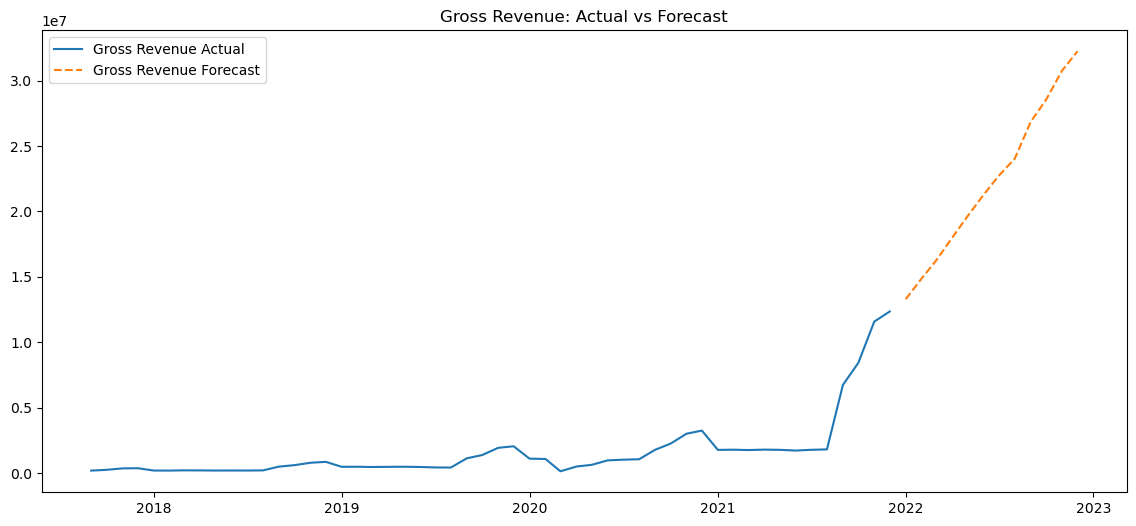

In [38]:
# Plot gross revenue forecast
plt.figure(figsize=(14, 6))
plt.plot(df_monthly['month'], df_monthly['gross_revenue'], label='Gross Revenue Actual')
plt.plot(df_forecast['month'], df_forecast['gross_revenue'], label='Gross Revenue Forecast', linestyle='--')
plt.legend()
plt.title('Gross Revenue: Actual vs Forecast')
plt.show()

- The forecast continues the sharp upward trend, predicting even higher revenues for the next year.
- The forecast assumes that the recent explosive growth is the “new normal” and will persist or even accelerate. Long flat period is ignored by model.
- It is mandatory to understend if the jump in late 2021 is sustainable or juat a unique period. 

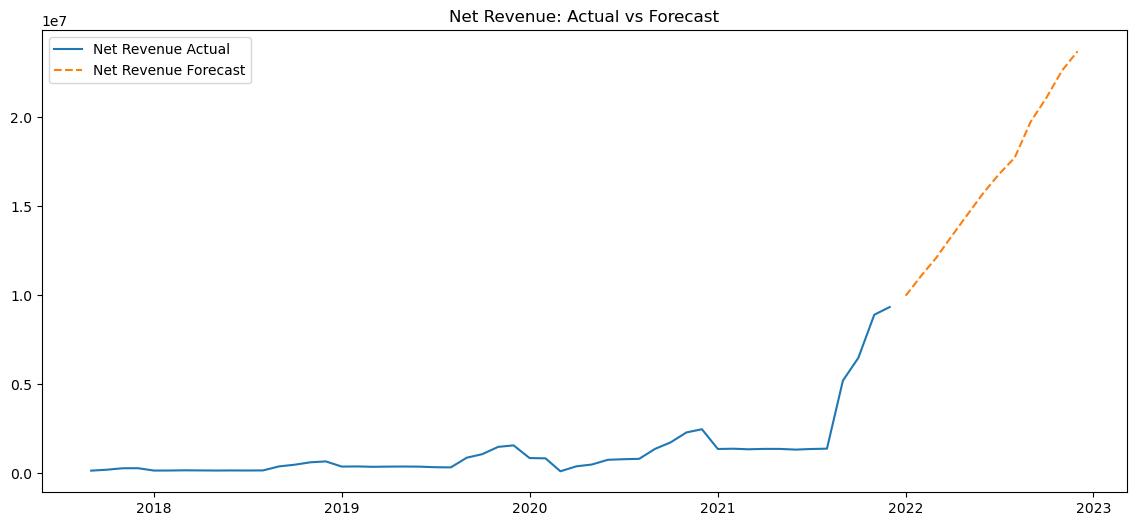

In [39]:
# Plot net revenue forecast
plt.figure(figsize=(14, 6))
plt.plot(df_monthly['month'], df_monthly['net_revenue'], label='Net Revenue Actual')
plt.plot(df_forecast['month'], df_forecast['net_revenue'], label='Net Revenue Forecast', linestyle='--')
plt.legend()
plt.title('Net Revenue: Actual vs Forecast')
plt.show()

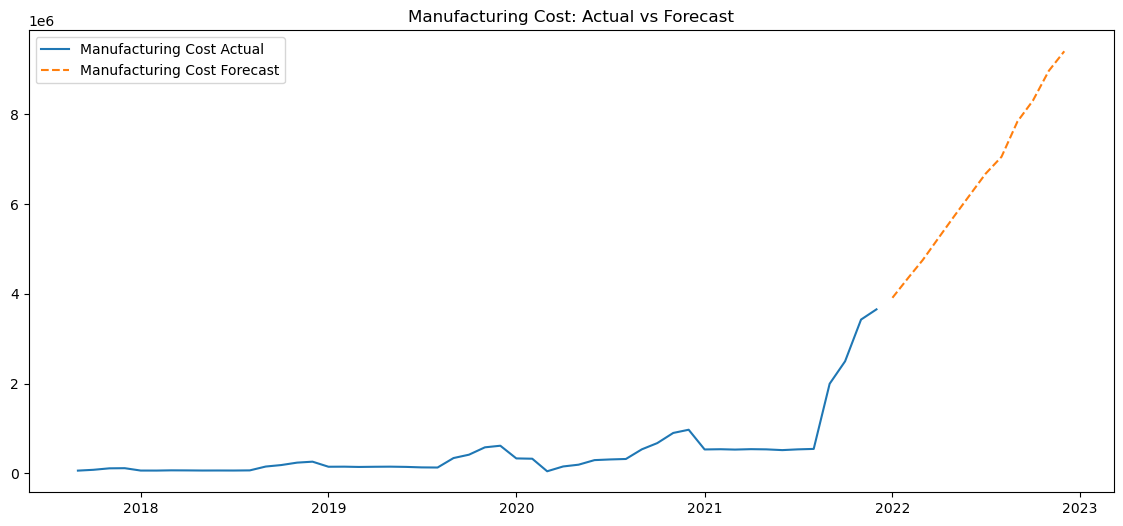

In [40]:
# Plot gross manufactoring forecast
plt.figure(figsize=(14, 6))
plt.plot(df_monthly['month'], df_monthly['gross_man'], label='Manufacturing Cost Actual')
plt.plot(df_forecast['month'], df_forecast['gross_man'], label='Manufacturing Cost Forecast', linestyle='--')
plt.legend()
plt.title('Manufacturing Cost: Actual vs Forecast')
plt.show()

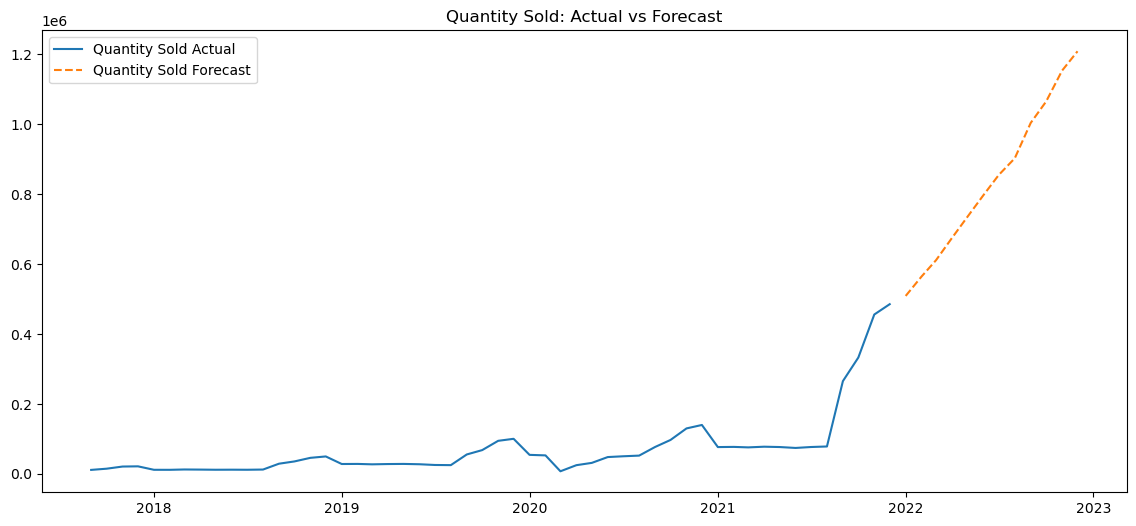

In [41]:
# Plot sold quantity forecast
plt.figure(figsize=(14, 6))
plt.plot(df_monthly['month'], df_monthly['total_sold_quantity'], label='Quantity Sold Actual')
plt.plot(df_forecast['month'], df_forecast['total_sold_quantity'], label='Quantity Sold Forecast', linestyle='--')
plt.legend()
plt.title('Quantity Sold: Actual vs Forecast')
plt.show()

In [42]:
display(df_forecast)

,month,gross_revenue,net_revenue,gross_man,total_sold_quantity
0,2022-01-01,1.329317e+07,9.985169e+06,3.911747e+06,5.090567e+05
1,2022-02-01,1.488134e+07,1.113423e+07,4.360481e+06,5.648060e+05
2,2022-03-01,1.624462e+07,1.210124e+07,4.754822e+06,6.112868e+05
3,2022-04-01,1.797265e+07,1.335613e+07,5.251395e+06,6.749350e+05
4,2022-05-01,1.962339e+07,1.453841e+07,5.729660e+06,7.352458e+05
5,2022-06-01,2.125503e+07,1.575882e+07,6.211511e+06,7.970614e+05
6,2022-07-01,2.273169e+07,1.679979e+07,6.675956e+06,8.552678e+05
7,2022-08-01,2.403322e+07,1.774703e+07,7.053685e+06,9.027244e+05
8,2022-09-01,2.684810e+07,1.976700e+07,7.840072e+06,1.003982e+06
9,2022-10-01,2.854266e+07,2.108652e+07,8.305499e+06,1.065305e+06


In [43]:
df_monthly['Type'] = 'Actual'
df_forecast['Type'] = 'Forecast'

In [44]:
df_monthly = df_monthly.rename(columns={'actual_col_name': 'Value'})
df_forecast = df_forecast.rename(columns={'forecast_col_name': 'Value'})

In [45]:
# Concatenate the df
df_combined = pd.concat([df_monthly, df_forecast], ignore_index=True)
df_combined

,month,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item,Type
0,2017-09-01,2.035608e+05,1.535497e+05,6.048768e+04,1.535497e+05,2.035608e+05,60487.6785,234.069666,1.142500e+04,13.439799,Actual
1,2017-10-01,2.645338e+05,2.040345e+05,7.849008e+04,3.575842e+05,4.680946e+05,138977.7623,340.057445,1.486000e+04,13.730449,Actual
2,2017-11-01,3.751914e+05,2.869923e+05,1.112728e+05,6.445764e+05,8.432860e+05,250250.5219,481.530674,2.101200e+04,13.658494,Actual
3,2017-12-01,3.855987e+05,2.907563e+05,1.145959e+05,9.353328e+05,1.228885e+06,364846.4305,491.973472,2.161500e+04,13.451599,Actual
4,2018-01-01,2.087000e+05,1.581922e+05,6.191038e+04,1.093525e+06,1.437585e+06,426756.8085,268.122444,1.171300e+04,13.505698,Actual
...,...,...,...,...,...,...,...,...,...,...,...
59,2022-08-01,2.403322e+07,1.774703e+07,7.053685e+06,NaN,NaN,NaN,NaN,9.027244e+05,NaN,Forecast
60,2022-09-01,2.684810e+07,1.976700e+07,7.840072e+06,NaN,NaN,NaN,NaN,1.003982e+06,NaN,Forecast
61,2022-10-01,2.854266e+07,2.108652e+07,8.305499e+06,NaN,NaN,NaN,NaN,1.065305e+06,NaN,Forecast
62,2022-11-01,3.076150e+07,2.264031e+07,8.970904e+06,NaN,NaN,NaN,NaN,1.153638e+06,NaN,Forecast


In [46]:
# Drop NA columns
df_combined = df_combined.drop([
    'cumulative_net_revenue',
    'cumulative_gross_revenue',
    'cumulative_gross_man',
    'avg_net_revenue',
    'avg_net_price_per_item'
], axis=1)

In [51]:
# Export
df_combined.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\actual_forecast_combined.csv', index=False)

### Forecast by Month and Market

In [62]:
# Making a forcast list of METRICS by month and market

# 1. Make sure month is datetime
df_monthly_market['month'] = pd.to_datetime(df_monthly_market['month'])
# 2. Get full range of months
all_months = pd.date_range(
    df_monthly_market['month'].min(),
    df_monthly_market['month'].max(),
    freq='MS'
)
forecast_list = []
# 3.
for market, group in df_monthly_market.groupby('market'):
    ts_gross_revenue = group.set_index('month')['gross_revenue'].reindex(all_months).fillna(0)
    ts_net_revenue = group.set_index('month')['net_revenue'].reindex(all_months).fillna(0)
    ts_gross_man = group.set_index('month')['gross_man'].reindex(all_months).fillna(0)
    ts_sold_quantity = group.set_index('month')['total_sold_quantity'].reindex(all_months).fillna(0)

    # Check minimum count for all metrics (at least 24 months)
    min_count = min(ts_gross_revenue.count(), ts_net_revenue.count(), ts_gross_man.count(), ts_sold_quantity.count())
    if min_count < 24:
        print(f"Skipping market {market}: not enough data (found {min_count} months)")
        continue

    try:
        model_gross = ExponentialSmoothing(ts_gross_revenue, trend='add', seasonal='add', seasonal_periods=12).fit()
        model_net = ExponentialSmoothing(ts_net_revenue, trend='add', seasonal='add', seasonal_periods=12).fit()
        model_man = ExponentialSmoothing(ts_gross_man, trend='add', seasonal='add', seasonal_periods=12).fit()
        model_sold = ExponentialSmoothing(ts_sold_quantity, trend='add', seasonal='add', seasonal_periods=12).fit()

        forecast_gross = model_gross.forecast(12)
        forecast_net = model_net.forecast(12)
        forecast_man = model_man.forecast(12)
        forecast_sold = model_sold.forecast(12)

        forecast_df = pd.DataFrame({
            'forecast_month': forecast_gross.index,
            'gross_revenue': forecast_gross.values,
            'net_revenue': forecast_net.values,
            'gross_man': forecast_man.values,
            'total_sold_quantity': forecast_sold.values,
            'market': market
        })

        forecast_list.append(forecast_df)
    except Exception as e:
        print(f"Failed for market {market}: {e}")
df_forecast_all = pd.concat(forecast_list, ignore_index=True)
print(df_forecast_all.head())


  forecast_month  gross_revenue    net_revenue      gross_man  \
0     2022-01-01  400621.050450  310750.453806  118214.397165   
1     2022-02-01  439513.109269  339861.993753  129633.925492   
2     2022-03-01  457260.068364  353108.331528  134788.605889   
3     2022-04-01  501074.818032  385447.109631  147700.851438   
4     2022-05-01  533855.042024  411131.644374  157294.696059   

   total_sold_quantity     market  
0         15363.398125  Australia  
1         16720.260671  Australia  
2         17055.681062  Australia  
3         18653.823627  Australia  
4         19807.766969  Australia  


In [63]:
df_monthly_market['Type'] = 'Actual'
df_forecast_all['Type'] = 'Forecast'

In [64]:
df_monthly_market = df_monthly_market.rename(columns={'actual_col_name': 'Value'})
df_forecast_all = df_forecast_all.rename(columns={'forecast_col_name': 'Value'})

In [65]:
# Copy forecast to avoid SettingWithCopyWarning
df_forecast_fixed = df_forecast_all.copy()
df_forecast_fixed['month'] = df_forecast_fixed['forecast_month']
df_forecast_fixed.drop(columns=['forecast_month'], inplace=True)

In [66]:
# Concatenate the df
df_combined_market = pd.concat([df_monthly_market, df_forecast_fixed], ignore_index=True)
df_combined_market = df_combined_market.sort_values(['market', 'month']).reset_index(drop=True)
df_combined_market

,month,market,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item,Type
0,2017-09-01,Australia,9.103130e+03,7.159401e+03,2700.588600,7159.401496,9103.1301,2700.5886,178.985037,513.000000,13.955948,Actual
1,2017-10-01,Australia,1.613863e+04,1.211508e+04,4787.264100,19274.485174,25241.7582,7487.8527,252.397577,896.000000,13.521299,Actual
2,2017-11-01,Australia,1.474173e+04,1.128937e+04,4378.811200,30563.859452,39983.4854,11866.6639,282.234357,816.000000,13.835017,Actual
3,2017-12-01,Australia,1.758575e+04,1.304276e+04,5223.432700,43606.620418,57569.2381,17090.0966,326.069024,990.000000,13.174506,Actual
4,2018-01-01,Australia,9.455196e+03,7.419758e+03,2799.455900,51026.378529,67024.4342,19889.5525,185.493953,531.000000,13.973179,Actual
...,...,...,...,...,...,...,...,...,...,...,...,...
1448,2022-08-01,United Kingdom,1.243304e+06,9.358803e+05,366591.128315,NaN,NaN,NaN,NaN,46448.898375,NaN,Forecast
1449,2022-09-01,United Kingdom,1.385656e+06,1.041915e+06,408619.861084,NaN,NaN,NaN,NaN,51755.471855,NaN,Forecast
1450,2022-10-01,United Kingdom,1.462980e+06,1.100542e+06,431399.868736,NaN,NaN,NaN,NaN,54689.286171,NaN,Forecast
1451,2022-11-01,United Kingdom,1.580724e+06,1.189706e+06,466139.448575,NaN,NaN,NaN,NaN,59117.610036,NaN,Forecast


In [61]:
# Export
df_combined_market.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\actual_forecast_combined_market.csv', index=False)

### Forecast by Month and product

In [67]:
# Making a forcast list of METRICS by month and product

# 1. Make sure month is datetime
df_monthly_product['month'] = pd.to_datetime(df_monthly_product['month'])
# 2. Get full range of months
all_months = pd.date_range(
    df_monthly_product['month'].min(),
    df_monthly_product['month'].max(),
    freq='MS'
)
forecast_list = []
# 3.
for product, group in df_monthly_product.groupby('product'):
    ts_gross_revenue = group.set_index('month')['gross_revenue'].reindex(all_months).fillna(0)
    ts_net_revenue = group.set_index('month')['net_revenue'].reindex(all_months).fillna(0)
    ts_gross_man = group.set_index('month')['gross_man'].reindex(all_months).fillna(0)
    ts_sold_quantity = group.set_index('month')['total_sold_quantity'].reindex(all_months).fillna(0)

    # Check minimum count for all metrics (at least 24 months)
    min_count = min(ts_gross_revenue.count(), ts_net_revenue.count(), ts_gross_man.count(), ts_sold_quantity.count())
    if min_count < 24:
        print(f"Skipping product {product}: not enough data (found {min_count} months)")
        continue

    try:
        model_gross = ExponentialSmoothing(ts_gross_revenue, trend='add', seasonal='add', seasonal_periods=12).fit()
        model_net = ExponentialSmoothing(ts_net_revenue, trend='add', seasonal='add', seasonal_periods=12).fit()
        model_man = ExponentialSmoothing(ts_gross_man, trend='add', seasonal='add', seasonal_periods=12).fit()
        model_sold = ExponentialSmoothing(ts_sold_quantity, trend='add', seasonal='add', seasonal_periods=12).fit()

        forecast_gross = model_gross.forecast(12)
        forecast_net = model_net.forecast(12)
        forecast_man = model_man.forecast(12)
        forecast_sold = model_sold.forecast(12)

        forecast_df = pd.DataFrame({
            'forecast_month': forecast_gross.index,
            'gross_revenue': forecast_gross.values,
            'net_revenue': forecast_net.values,
            'gross_man': forecast_man.values,
            'total_sold_quantity': forecast_sold.values,
            'product': product
        })

        forecast_list.append(forecast_df)
    except Exception as e:
        print(f"Failed for product {product}: {e}")
df_forecast_all = pd.concat(forecast_list, ignore_index=True)
print(df_forecast_all.head())


  forecast_month  gross_revenue   net_revenue     gross_man  \
0     2022-01-01   2.461893e+06  1.849092e+06  7.545996e+05   
1     2022-02-01   2.698068e+06  2.014546e+06  8.271020e+05   
2     2022-03-01   2.845244e+06  2.115950e+06  8.762876e+05   
3     2022-04-01   3.140134e+06  2.328196e+06  9.677585e+05   
4     2022-05-01   3.393204e+06  2.510912e+06  1.047431e+06   

   total_sold_quantity                                            product  
0         98902.112329  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  
1        106810.561238  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  
2        110185.111000  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  
3        121128.498530  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  
4        129917.339660  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  


In [75]:
df_monthly_product['Type'] = 'Actual'
df_forecast_all['Type'] = 'Forecast'

In [76]:
df_monthly_product = df_monthly_product.rename(columns={'actual_col_name': 'Value'})
df_forecast_all = df_forecast_all.rename(columns={'forecast_col_name': 'Value'})

In [77]:
# Copy forecast to avoid SettingWithCopyWarning
df_forecast_fixed = df_forecast_all.copy()
df_forecast_fixed['month'] = df_forecast_fixed['forecast_month']
df_forecast_fixed.drop(columns=['forecast_month'], inplace=True)
df_forecast_fixed.head()

,gross_revenue,net_revenue,gross_man,total_sold_quantity,product,Type,month
0,2.461893e+06,1.849092e+06,7.545996e+05,98902.112329,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Forecast,2022-01-01
1,2.698068e+06,2.014546e+06,8.271020e+05,106810.561238,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Forecast,2022-02-01
2,2.845244e+06,2.115950e+06,8.762876e+05,110185.111000,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Forecast,2022-03-01
3,3.140134e+06,2.328196e+06,9.677585e+05,121128.498530,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Forecast,2022-04-01
4,3.393204e+06,2.510912e+06,1.047431e+06,129917.339660,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Forecast,2022-05-01


In [78]:
# Concatenate the df
df_combined_product = pd.concat([df_monthly_product, df_forecast_fixed], ignore_index=True)
df_combined_product = df_combined_product.sort_values(['product', 'month']).reset_index(drop=True)
df_combined_product

,month,product,gross_revenue,net_revenue,gross_man,cumulative_net_revenue,cumulative_gross_revenue,cumulative_gross_man,avg_net_revenue,total_sold_quantity,avg_net_price_per_item,Type
0,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,9.676652e+04,7.332372e+04,2.893501e+04,73323.720440,96766.5191,28935.0108,224.231561,5237.000000,14.001092,Actual
1,2017-10-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,1.195826e+05,9.246491e+04,3.568861e+04,165788.627416,216349.0741,64623.6165,307.192382,6472.000000,14.286914,Actual
2,2017-11-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,1.780656e+05,1.357993e+05,5.315164e+04,301587.965207,394414.6881,117775.2554,455.702476,9642.000000,14.084146,Actual
3,2017-12-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,1.769921e+05,1.332624e+05,5.301950e+04,434850.392896,571406.8053,170794.7588,450.210904,9572.000000,13.922109,Actual
4,2018-01-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,9.697077e+04,7.338644e+04,2.887535e+04,508236.833511,668377.5771,199670.1106,251.323427,5223.000000,14.050630,Actual
...,...,...,...,...,...,...,...,...,...,...,...,...
215,2022-08-01,AQ Zion Saga,9.526369e+06,7.026854e+06,2.803765e+06,NaN,NaN,NaN,NaN,324389.520193,NaN,Forecast
216,2022-09-01,AQ Zion Saga,1.060371e+07,7.816805e+06,3.119487e+06,NaN,NaN,NaN,NaN,361408.642270,NaN,Forecast
217,2022-10-01,AQ Zion Saga,1.120641e+07,8.244650e+06,3.296085e+06,NaN,NaN,NaN,NaN,384500.114846,NaN,Forecast
218,2022-11-01,AQ Zion Saga,1.204008e+07,8.861290e+06,3.542174e+06,NaN,NaN,NaN,NaN,411377.243090,NaN,Forecast


In [79]:
# Export
df_combined_product.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\actual_forecast_combined_product.csv', index=False)

### Forecast Pre-Jump data only (Exponential Smoothing)

In [71]:
# Define breakpoint and split the df
breakpoint = pd.Timestamp('2021-08-01')

df_pre = df_monthly[df_monthly['month'] < breakpoint]
df_post = df_monthly[df_monthly['month'] >= breakpoint]

In [72]:
# Descriptive statistics for each period (gross_revenue)
print("Pre-jump stats:")
print(df_pre['gross_revenue'].describe())
print("\nPost-jump stats:")
print(df_post['gross_revenue'].describe())

Pre-jump stats:
count    4.700000e+01
mean     9.700810e+05
std      7.871945e+05
min      1.536568e+05
25%      3.803950e+05
50%      6.204582e+05
75%      1.755568e+06
max      3.261303e+06
Name: gross_revenue, dtype: float64

Post-jump stats:
count    5.000000e+00
mean     8.192420e+06
std      4.230233e+06
min      1.825893e+06
25%      6.747838e+06
50%      8.440107e+06
75%      1.158943e+07
max      1.235883e+07
Name: gross_revenue, dtype: float64


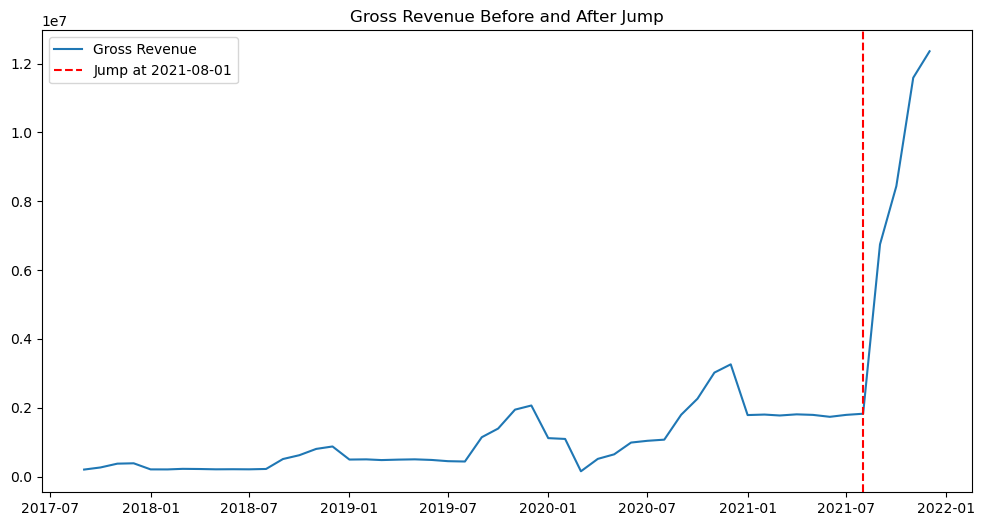

In [74]:
# plot of gross revenue
plt.figure(figsize=(12,6))
plt.plot(df_monthly['month'], df_monthly['gross_revenue'], label='Gross Revenue')
plt.axvline(breakpoint, color='red', linestyle='--', label='Jump at 2021-08-01')
plt.legend()
plt.title('Gross Revenue Before and After Jump')
plt.show()

In [77]:
# Growth Rate Analysis
df_pre.loc[:, 'revenue_growth'] = df_pre['gross_revenue'].pct_change()
df_post.loc[:, 'revenue_growth'] = df_post['gross_revenue'].pct_change()

print("Average Pre-jump Growth Rate:", df_pre['revenue_growth'].mean())
print("Average Post-jump Growth Rate:", df_post['revenue_growth'].mean())


Average Pre-jump Growth Rate: 0.1472399991397819
Average Post-jump Growth Rate: 0.8464874028990409


The post jump period is to short to make a forecast.  
I will forcast the pre jump period alone.

In [79]:
# Fit the model only on pre-jump data
pre_model = ExponentialSmoothing(
    df_pre['gross_revenue'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# Forecast 12 months ahead from the last pre-jump month
last_pre_month = df_pre['month'].max()
forecast_months_pre = pd.date_range(last_pre_month + pd.offsets.MonthBegin(), periods=12, freq='MS')

pre_forecast = pre_model.forecast(12)

df_pre_forecast = pd.DataFrame({
    'month': forecast_months_pre,
    'gross_revenue_forecast': pre_forecast.values
})


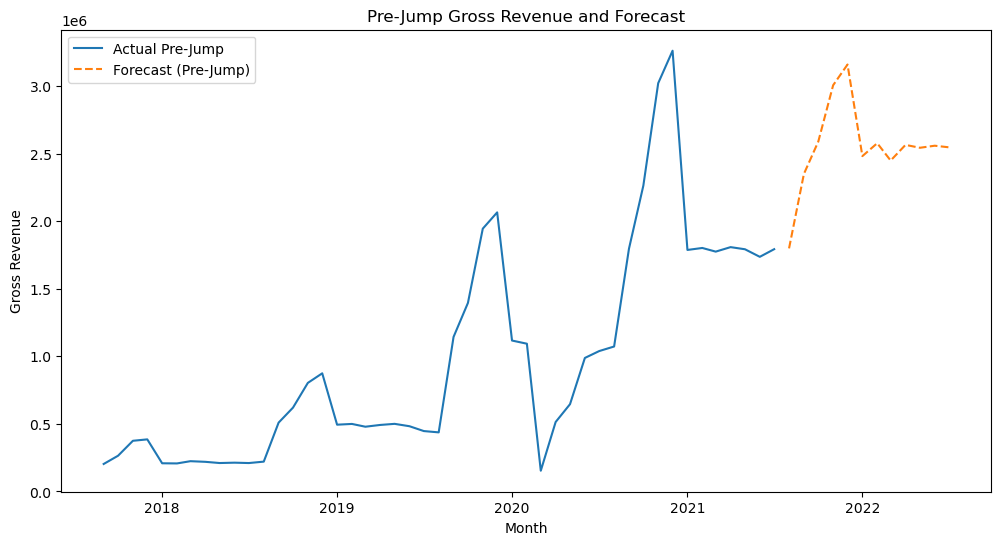

In [80]:
plt.figure(figsize=(12,6))
plt.plot(df_pre['month'], df_pre['gross_revenue'], label='Actual Pre-Jump')
plt.plot(df_pre_forecast['month'], df_pre_forecast['gross_revenue_forecast'],
         label='Forecast (Pre-Jump)', linestyle='--')
plt.title('Pre-Jump Gross Revenue and Forecast')
plt.xlabel('Month')
plt.ylabel('Gross Revenue')
plt.legend()
plt.show()


- The forecast (dashed orange) begins from the end of the pre-jump period and extends for 12 months. It appears to follow the most recent actual values closely, then stabilizes.
- The model is capturing recent spikes but is not projecting strong future growth—it expects values similar to the latest observed period, adjusting for seasonality.

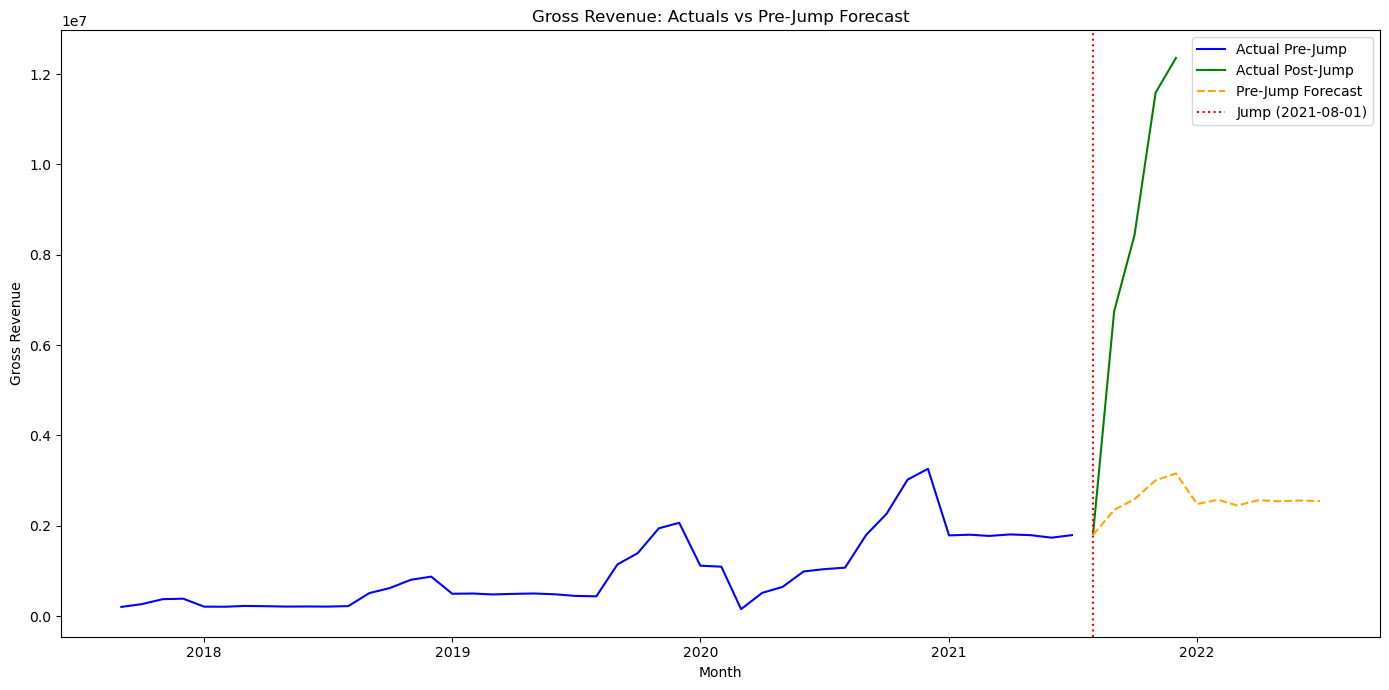

In [81]:
import matplotlib.pyplot as plt

breakpoint = pd.Timestamp('2021-08-01')

plt.figure(figsize=(14, 7))

# 1. Plot pre-jump actuals
plt.plot(
    df_monthly[df_monthly['month'] < breakpoint]['month'],
    df_monthly[df_monthly['month'] < breakpoint]['gross_revenue'],
    label='Actual Pre-Jump',
    color='blue'
)

# 2. Plot post-jump actuals
plt.plot(
    df_monthly[df_monthly['month'] >= breakpoint]['month'],
    df_monthly[df_monthly['month'] >= breakpoint]['gross_revenue'],
    label='Actual Post-Jump',
    color='green'
)

# 3. Plot pre-jump forecast
plt.plot(
    df_pre_forecast['month'],
    df_pre_forecast['gross_revenue_forecast'],
    label='Pre-Jump Forecast',
    color='orange',
    linestyle='--'
)

# Mark the breakpoint
plt.axvline(breakpoint, color='red', linestyle=':', label='Jump (2021-08-01)')

plt.title('Gross Revenue: Actuals vs Pre-Jump Forecast')
plt.xlabel('Month')
plt.ylabel('Gross Revenue')
plt.legend()
plt.tight_layout()
plt.show()


Pre-jump forecasting models completely miss the dramatic real-world increase in revenue after the structural break.  
This visually justifies splitting the periods for modeling.  
post-jump period can not be forecasted. the best thing is to obtain more sales data and then make a forecast. 

In [8]:
# Creating a joined table of metrics
query = """SELECT * FROM dim_customer;
"""
df = pd.read_sql_query(query, con)
df.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\dim_customer.csv', index=False)

In [9]:
# Creating a joined table of metrics
query = """SELECT * FROM dim_product;
"""
df = pd.read_sql_query(query, con)
df.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\dim_product.csv', index=False)

In [10]:
# Creating a joined table of metrics
query = """SELECT * FROM fact_pre_discount;
"""
df = pd.read_sql_query(query, con)
df.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\fact_pre_discount.csv', index=False)

In [11]:
# Creating a joined table of metrics
query = """SELECT * FROM fact_manufacturing_cost;
"""
df = pd.read_sql_query(query, con)
df.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\fact_manufacturing_cost.csv', index=False)

In [12]:
# Creating a joined table of metrics
query = """SELECT * FROM fact_gross_price;
"""
df = pd.read_sql_query(query, con)
df.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\fact_gross_price.csv', index=False)

In [13]:
# Creating a joined table of metrics
query = """SELECT * FROM fact_sales_monthly;
"""
df = pd.read_sql_query(query, con)
df.to_csv('C:\\Users\\Daiana\\Desktop\\Final project\\fact_sales_monthly.csv', index=False)

## Tableau Dashboard

Link for AtliQ Hardware Financial Analisys Dashboard: https://public.tableau.com/app/profile/daiana.palkin/viz/FinalProject22_07_25/Dashboard-AtliQHardwareFinancialAnalisys?publish=yes

Conclusion:  
AtliQ Hardware’s financial metrics show strong and accelerating growth in all metrics over the past few years, especially in recent quarters. The company’s revenue is widely distributed across multiple countries, with significant contributions from India, and USA. The actual vs. forecast chart demonstrates not only robust historical growth but also a confident projection of continued expansion into the future. However, it is important to note that the most recent data includes an unusually large and atypical jump in net revenue. This spike may be due to exceptional circumstances or one-off events, rather than an ongoing trend.

Key products such as the AQ Dracula HDD and AQ Zion Saga are major revenue drivers, while the seasonality chart indicates peak sales in the final quarter of the year, especially in October, November, and December.